### **Final Project Report — CAS Applied Data Science | PROJECT NOTEBOOK**  

**Łukasz Maciaś**

lukasz.macias.01@gmail.com




---



### **(1) DATA COLLECTION AND FEATURE ENGINEERING**



---



**Data Sources**:
1. Yahoo Finance (yfinance API)
2. US Federal Reselves Bank (fredapi API)



---



### 📊 **Project Goal**

The objective of this analysis is to **predict the price movements of S&P 500** using:

- 🧠 **Machine Learning models** (Random Forest and XGBoost)

These models are trained on a combination of:
- 💹 **Stock-Specifict Features**
- 📈 **Technical analysis indicators**
- 🌍 **Macroeconomic features** (e.g., interest rates, money supply, inflation)



---



### 📊 **FEATURES OVERVIEW**

### 💹  **Stock-Specific Features**

| **Category** | **Feature** | **Typical Parameters / Source** | **Intuition / Why It Helps** |
|--------------|-------------|----------------------------------|------------------------------|
| **Price Action** | **(1) Daily OHLC Prices** | Open, High, Low, Close (Yahoo Finance) | Basic building blocks for all technical analysis; show market range and direction. |
| | **(2) Daily Price Movement** | Close_t – Close_(t‑1), % change | Captures daily trend, momentum, and return behavior. |
| **Volatility** | **(3) Daily Volatility** | std. dev. of intraday returns or close-to-close | Measures risk/uncertainty; high volatility often linked to earnings, news, etc. |
| **Volume / Flow** | **(4) Trading Volume** | Daily volume (Yahoo Finance) | Tracks investor participation; spikes often signal turning points or breakouts. |
| **Returns to Investors** | **(5) Dividend Payments** | Cash dividend per share (Yahoo Finance) | Impacts total return; relevant for valuation, especially in mature tech firms. |


### 📈 **Technical Analysis Indicators**

| Category | Feature | Typical Parameters | Intuition / Why It Helps |
|----------|---------|--------------------|--------------------------|
| **Trend & Momentum** | **(1) Moving Averages** | 5‑, 10‑, 20‑, 50‑, 200‑day | Captures prevailing trend and lagged momentum. |
| | **(2) Relative Strength Index (RSI)** | 14‑day (or 7/21) | Overbought/oversold oscillator (0‑100). |
| | **(3) Rate of Change (ROC)** | 5‑ or 10‑day | Percentage change in price; pure momentum gauge. |
| **Volume/Flow** | **(4) On‑Balance Volume (OBV)** | cumulative | Combines volume and direction; confirms price moves. |
| **Market Structure** | **(5) VWAP Deviation** | intraday → daily close | Price relative to volume‑weighted average price. |
| | **(6) High‑Low & Close Location Value (CLV)** | daily | Where the close sits inside day’s range; buyers vs. sellers control. |
| **Cross‑Asset / Macro** | **(7) S&P500 vs. Nasdaq‑100** | price ratio | Normalized Relative strength to benchmark. |
| | **(8) Implied Volatility (VIX level)** | daily | Sentiment & risk‑aversion proxy that influences tech stocks. |

### 🌍 **Macroeconomic Indicators**

| **Category** | **Feature** | **FRED/Yahoo ID / Typical Data** | **Intuition / Why It Helps** |
|--------------|-------------|-------------------------------|------------------------------|
| **Monetary Policy** | **(1) Interest Rates** | Fed Funds Rate (FEDFUNDS) | Drives borrowing costs, discounting future earnings — critical for tech valuations. |
| **Inflation** | **(2) Consumer Price Index (CPI)** | CPIAUCSL | Captures inflation trends, affecting central bank policy and real returns. |
| **Labor Market** | **(3) Employment Level** | PAYEMS (Nonfarm Payrolls) | Strong labor = strong economy = demand for tech; weak = risk-off sentiment. |
| **Currency Strength** | **(4) US Dollar Index** | DXY (Yahoo Finance) | Affects global tech revenue (e.g., Apple); strong dollar = headwind for exports. |
| **Commodities** | **(5) Crude Oil Prices** | WTI Crude (CL=F on Yahoo) | Proxy for global demand & inflation pressure; influences Fed policy indirectly. |
| **Consumer Behavior** | **(6) Consumer Sentiment Index** | UMCSENT (Univ. of Michigan) | Forward-looking indicator of consumer confidence, tech adoption, and spending. |
| **Liquidity** | **(7) Money Supply (M1 / M2)** | M1SL, M2SL | Measures available liquidity in the economy; supports asset price growth. |




---



### 📊 **FEATURE COLLECTION**

In [ ]:
!pip install fredapi

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from typing import Optional, Tuple
import matplotlib.pyplot as plt
from fredapi import Fred

In [ ]:
# select stock ticker and time scope of the analysis

ticker = "^GSPC"
start = "2015-01-01"
end = "2025-03-01"

In [ ]:
def get_fred(start, end):
    start_less_1y = pd.to_datetime(start) - pd.Timedelta(days=365)

    date_range = pd.date_range(start=start_less_1y, end=end, freq='D')
    df_dates = pd.DataFrame({'Date': date_range})

    # FRED setup
    api_key = '4b2fa1d7232a488aaf686fe22123a2bc'
    fred = Fred(api_key=api_key)

    # Initialize merged_df with df_dates to include the Date column
    merged_df = df_dates.copy()

    # Loop over each series in 'i' and merge the data
    i = ['M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS', 'UMCSENT']
    for j in i:
        # Get series data from FRED
        fred_data = fred.get_series(j)
        fred_data = fred_data.to_frame()
        fred_data.columns = [j]  # Rename column to the series name

        # Merge the data into merged_df
        merged_df = merged_df.merge(fred_data, how='left', left_on='Date', right_index=True)

    merged_df[i] = merged_df[i].ffill()

    return merged_df

In [ ]:
def get_stock_price(ticker: str,
                    start: Optional[str] = None,
                    end:   Optional[str] = None,
                    period: str = "5y") -> pd.DataFrame:

    if start is None:
        raw = yf.download(ticker, period=period, interval="1d", actions=True, auto_adjust=False)
    else:
        raw = yf.download(ticker, start=start, end=end, interval="1d", actions=True, auto_adjust=False)

    # Rename for consistency
    df = raw.rename(columns={
        "Open":         "open",
        "High":         "high",
        "Low":          "low",
        "Close":        "close",
        "Adj Close":    "adj_close",
        "Volume":       "volume",
        "Dividends":    "dividend_cash",
        "Stock Splits": "split_ratio"
    })

    df["daily_volatility"] = df["high"]  - df["low"]
    df["daily_movement"]   = df["close"] - df["open"]

    df = df[["close", "high", "low", "open", "volume", "daily_volatility", "daily_movement"]]

    df.columns = df.columns.get_level_values(0)

    df["ticker"] = ticker

    # add VIX, SP500, NASDAQ

    bench = ['^VIX', "^IXIC", "^IRX", "^FVX", "^TNX", "^TYX", "CL=F", "DX-Y.NYB"] # CL=F - WTI crude oil

    for i in bench:
        if start is None:
            raw = yf.download(i, period=period, interval="1d", actions=True, auto_adjust=False)
        else:
            raw = yf.download(i, start=start, end=end, interval="1d", actions=True, auto_adjust=False)

        raw = raw["Close"]

        df = df.join(raw, how="left")

    df['VIX_pct_change'] = df['^VIX'].pct_change()
    df['VIX_lag1'] = df['^VIX'].shift(1)
    df['VIX_lag2'] = df['^VIX'].shift(2)

    # add FRED data

    print("retriving FRED")
    fred = get_fred(start=start, end=end)

    df = df.merge(fred, how='left', left_index=True, right_on='Date')
    df['Date2'] = df['Date']
    df = df.set_index('Date2')

    return df

In [ ]:

def add_moving_average(df: pd.DataFrame,
                       price_col: str = "close",
                       window: int = 20,
                       ma_col: str | None = None,
                       min_periods: int | None = None) -> pd.DataFrame:

    if price_col not in df.columns:
        raise KeyError(f"Column '{price_col}' not found in DataFrame.")

    if ma_col is None:
        ma_col = f"{price_col}_ma{window}"

    df[ma_col] = (
        df[price_col]
        .rolling(window=window, min_periods=min_periods or window)
        .mean()
    )

    return df


### **STEP 1 - Retrival of Stock specific and Macroeconomic features**

In [ ]:
stock = get_stock_price(ticker, start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


retriving FRED


In [ ]:
stock.columns

Index(['close', 'high', 'low', 'open', 'volume', 'daily_volatility',
       'daily_movement', 'ticker', '^VIX', '^IXIC', '^IRX', '^FVX', '^TNX',
       '^TYX', 'CL=F', 'DX-Y.NYB', 'VIX_pct_change', 'VIX_lag1', 'VIX_lag2',
       'Date', 'M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS', 'UMCSENT'],
      dtype='object')

In [ ]:
stock

,close,high,low,open,volume,daily_volatility,daily_movement,ticker,^VIX,^IXIC,...,DX-Y.NYB,VIX_pct_change,VIX_lag1,VIX_lag2,Date,M1SL,M2SL,CPIAUCSL,PAYEMS,UMCSENT
Date2,,,,,,,,,,,,,,,,,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,26.320068,-0.699951,^GSPC,17.790001,4726.810059,...,91.080002,NaN,NaN,NaN,2015-01-02,2955.6,11788.8,234.747,140568.0,98.1
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,37.099976,-33.859985,^GSPC,19.920000,4652.569824,...,91.379997,0.119730,17.790001,NaN,2015-01-05,2955.6,11788.8,234.747,140568.0,98.1
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,37.810059,-19.540039,^GSPC,21.120001,4592.740234,...,91.500000,0.060241,19.920000,17.790001,2015-01-06,2955.6,11788.8,234.747,140568.0,98.1
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,24.059937,20.349976,^GSPC,19.309999,4650.470215,...,91.889999,-0.085701,21.120001,19.920000,2015-01-07,2955.6,11788.8,234.747,140568.0,98.1
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,33.470093,31.529907,^GSPC,17.010000,4736.189941,...,92.370003,-0.119109,19.309999,21.120001,2015-01-08,2955.6,11788.8,234.747,140568.0,98.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,5983.250000,6043.649902,5977.830078,6026.689941,4990120000,65.819824,-43.439941,^GSPC,18.980000,19286.929688,...,106.599998,0.042284,18.209999,15.660000,2025-02-24,18531.1,21670.5,319.775,159170.0,64.7
2025-02-25,5955.250000,5992.649902,5908.490234,5982.729980,5374690000,84.159668,-27.479980,^GSPC,19.430000,19026.390625,...,106.309998,0.023709,18.980000,18.209999,2025-02-25,18531.1,21670.5,319.775,159170.0,64.7
2025-02-26,5956.060059,6009.819824,5932.689941,5970.870117,4869580000,77.129883,-14.810059,^GSPC,19.100000,19075.259766,...,106.419998,-0.016984,19.430000,18.980000,2025-02-26,18531.1,21670.5,319.775,159170.0,64.7


In [ ]:
# @title
def plot_two_lines_secondary_axis(df, col1, col2):
    fig, ax1 = plt.subplots(figsize=(12,6))

    ax1.plot(df.index, df[col1], color='blue', label=col1)
    ax1.set_ylabel(col1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df.index, df[col2], color='red', label=col2)
    ax2.set_ylabel(col2, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f"{col1} and {col2} Over Time")
    fig.tight_layout()
    plt.show()


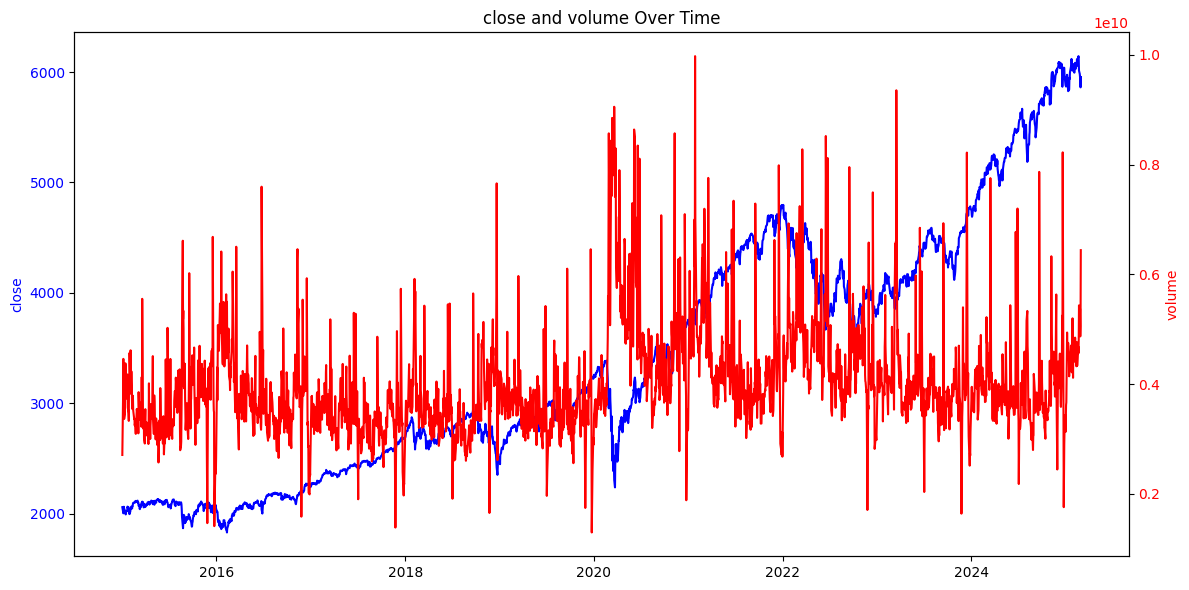

In [ ]:
plot_two_lines_secondary_axis(stock,'close', 'volume')

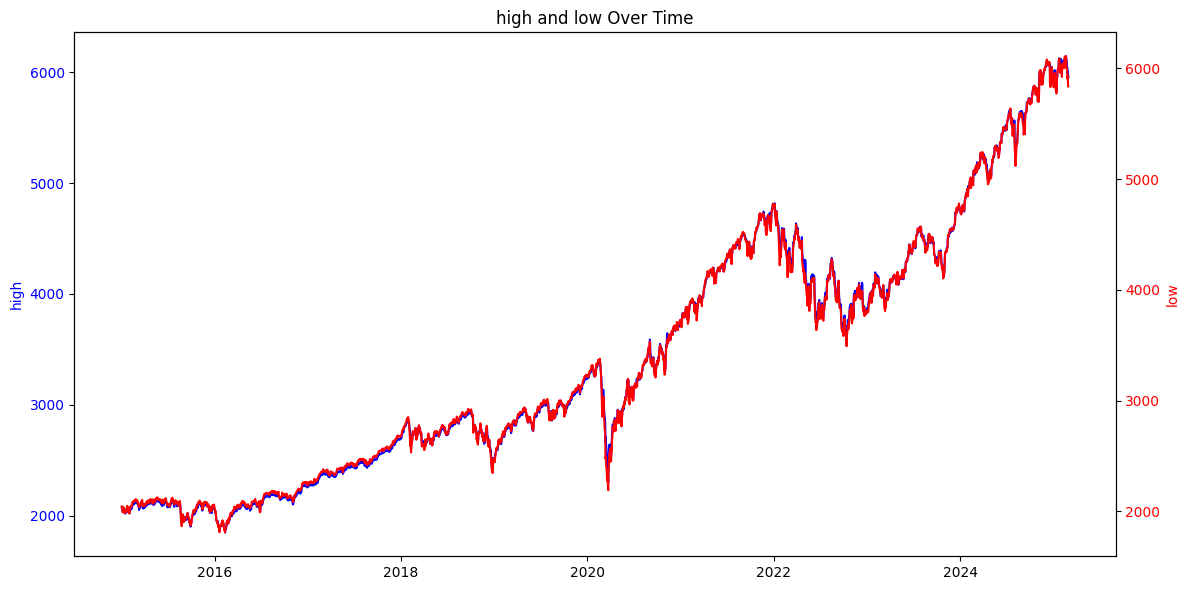

In [ ]:
plot_two_lines_secondary_axis(stock,'high', 'low')

In [ ]:
stock.columns

Index(['close', 'high', 'low', 'open', 'volume', 'daily_volatility',
       'daily_movement', 'dividend_cash', 'ticker', '^VIX', '^GSPC', '^IXIC',
       '^IRX', '^FVX', '^TNX', '^TYX', 'CL=F', 'DX-Y.NYB', 'VIX_pct_change',
       'VIX_lag1', 'VIX_lag2', 'Date', 'M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS',
       'UMCSENT'],
      dtype='object')

### **STEP 2 - Retrival of Technical Indicator features**

**(1) Moving Averages**

Moving Averages smooth out price noise, reveal the underlying trend, and act as dynamic support and resistance levels — essential for spotting trend direction and reversals.

In [ ]:
def add_mv(df):

    ma_windows = [5, 10, 20, 50, 200]  # List of moving average windows

    for window in ma_windows:
        ma_col = f"Close_MA{window}"
        df = add_moving_average(
            df,
            price_col="close",
            window=window,
            ma_col=ma_col,
            min_periods=1
        )

    return df

In [ ]:
stock = add_mv(stock)

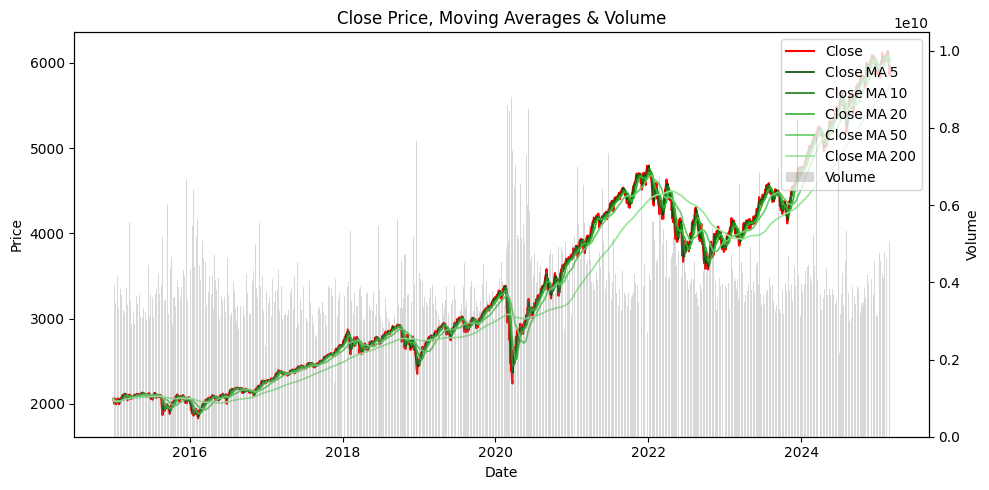

In [ ]:
# @title
price_color    = "red"
green_dark     = "#004d00"
green_medium   = "#1a7f1a"
green_light    = "#33b333"
green_lighter  = "#66cc66"
green_bright   = "#99e699"
volume_color   = "gray"

fig, ax_price = plt.subplots(figsize=(10, 5))

ax_price.plot(stock.index, stock["close"],        label="Close",        color=price_color, linewidth=1.5)
ax_price.plot(stock.index, stock["Close_MA5"],    label="Close MA 5",   color=green_dark,    linewidth=1.2)
ax_price.plot(stock.index, stock["Close_MA10"],   label="Close MA 10",  color=green_medium,  linewidth=1.2)
ax_price.plot(stock.index, stock["Close_MA20"],   label="Close MA 20",  color=green_light,   linewidth=1.2)
ax_price.plot(stock.index, stock["Close_MA50"],   label="Close MA 50",  color=green_lighter, linewidth=1.2)
ax_price.plot(stock.index, stock["Close_MA200"],  label="Close MA 200", color=green_bright,  linewidth=1.2)

ax_price.set_xlabel("Date")
ax_price.set_ylabel("Price")
ax_price.set_title("Close Price, Moving Averages & Volume")

ax_vol = ax_price.twinx()                               # secondary y‑axis
ax_vol.bar(stock.index, stock["volume"],                # assumes a 'volume' column
           label="Volume", color=volume_color,
           alpha=0.3, width=1.0)
ax_vol.set_ylabel("Volume")

lines_price, labels_price = ax_price.get_legend_handles_labels()
lines_vol,   labels_vol   = ax_vol.get_legend_handles_labels()
ax_price.legend(lines_price + lines_vol,
                labels_price + labels_vol,
                loc="upper right")

plt.tight_layout()
plt.show()

**(2) 14 days Relative Strength Index (RSI)**

https://en.wikipedia.org/wiki/Relative_strength_index

https://www.investorsunderground.com/rsi-relative-strength-index/

 John J. Murphy (2009). The Visual Investor: How to Spot Market Trends (2nd ed.). John Wiley and Sons. p. 100. ISBN 9780470382059.

The **Relative Strength Index (RSI)** is a momentum oscillator that measures the speed and change of price movements. It works by comparing the magnitude of recent **gains** to recent **losses**.

### **RSI Calculation**


**1. Find Daily Changes:**  

Positive → **Gains**, Negative → **Losses** (via `diff()`).

**2. Smooth Gains and Losses:**   

Apply **Exponential Moving Average (EMA)** to gains and losses.


**3. Compute Relative Strength (RS):**  

RS = avg_gain / avg_loss


**4. Calculate RSI:**  

RSI = 100 - (100 / 1 + RS)

**5. Interpretation:**  
- **RSI ≥ 70** → Overbought  
- **RSI ≤ 30** → Oversold


Why RSI matters:
* helping traders to time trade entry, exit, and anticipate trend reversals.


In [ ]:
def add_rsi(df: pd.DataFrame,
            price_col: str = "close",
            window: int = 14,
            rsi_col: str | None = None) -> pd.DataFrame:

    if rsi_col is None:
        rsi_col = f"RSI{window}"

    if price_col not in df.columns:
        raise KeyError(f"Column '{price_col}' not found.")

    # 1. price differences
    delta = df[price_col].diff()

    # 2. separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # 3. exponential moving average of gains & losses
    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()

    # 4. relative strength (RS) and RSI
    rs  = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))

    df[rsi_col] = rsi

    return df

In [ ]:
stock = add_rsi(stock)

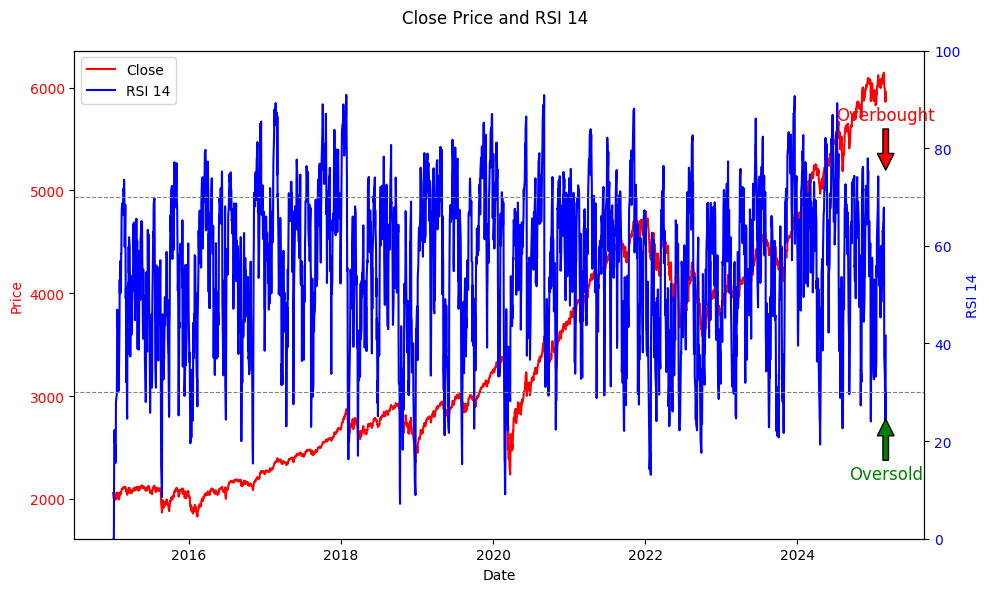

In [ ]:
# @title
fig, ax_price = plt.subplots(figsize=(10, 6))

# ── price on left y‑axis ──────────────────────────────────────
ax_price.plot(stock.index, stock["close"], color="red", label="Close")
ax_price.set_xlabel("Date")
ax_price.set_ylabel("Price", color="red")
ax_price.tick_params(axis="y", labelcolor="red")

# ── RSI on right y‑axis ───────────────────────────────────────
ax_rsi = ax_price.twinx()
ax_rsi.plot(stock.index, stock["RSI14"], color="blue", label="RSI 14")
ax_rsi.set_ylabel("RSI 14", color="blue")
ax_rsi.tick_params(axis="y", labelcolor="blue")
ax_rsi.axhline(70, color="gray", linestyle="--", linewidth=0.8)   # overbought
ax_rsi.axhline(30, color="gray", linestyle="--", linewidth=0.8)   # oversold
ax_rsi.set_ylim(0, 100)

# ── annotations for overbought and oversold areas ─────────────
ax_rsi.annotate('Overbought', xy=(stock.index[-1], 75), xytext=(stock.index[-1], 85),
                arrowprops=dict(facecolor='red', shrink=0.05), color='red', fontsize=12,
                horizontalalignment='center', verticalalignment='bottom')
ax_rsi.annotate('Oversold', xy=(stock.index[-1], 25), xytext=(stock.index[-1], 15),
                arrowprops=dict(facecolor='green', shrink=0.05), color='green', fontsize=12,
                horizontalalignment='center', verticalalignment='top')

# ── title & legend ────────────────────────────────────────────
fig.suptitle("Close Price and RSI 14")
lines_price, labels_price = ax_price.get_legend_handles_labels()
lines_rsi,   labels_rsi   = ax_rsi.get_legend_handles_labels()
ax_price.legend(lines_price + lines_rsi,
                labels_price + labels_rsi,
                loc="upper left")

plt.tight_layout()
plt.show()

**(3) Rate Of Change (ROC)**

 The **Rate of Change (ROC)** is a simple measure used to understand how much a stock price has changed over a specific period. It tells us the percentage difference between the current price and the price from a previous point in time.

Example:
If the stock closed at 100 today and 95 5 days ago:

    ROC = ((100 - 95) / 95) * 100 = 5.26%

Why it matters:

ROC helps traders understand the momentum of a stock:
* A high positive ROC means the stock is going up quickly (momentum is strong).
* A negative ROC means the stock is losing value.

In [ ]:
def add_roc(df: pd.DataFrame, column: str, period: int) -> pd.DataFrame:

    roc_col = f'ROC_{period}d'
    df[roc_col] = df[column].pct_change(periods=period) * 100
    return df

In [ ]:
stock = add_roc(stock, 'close', 5)

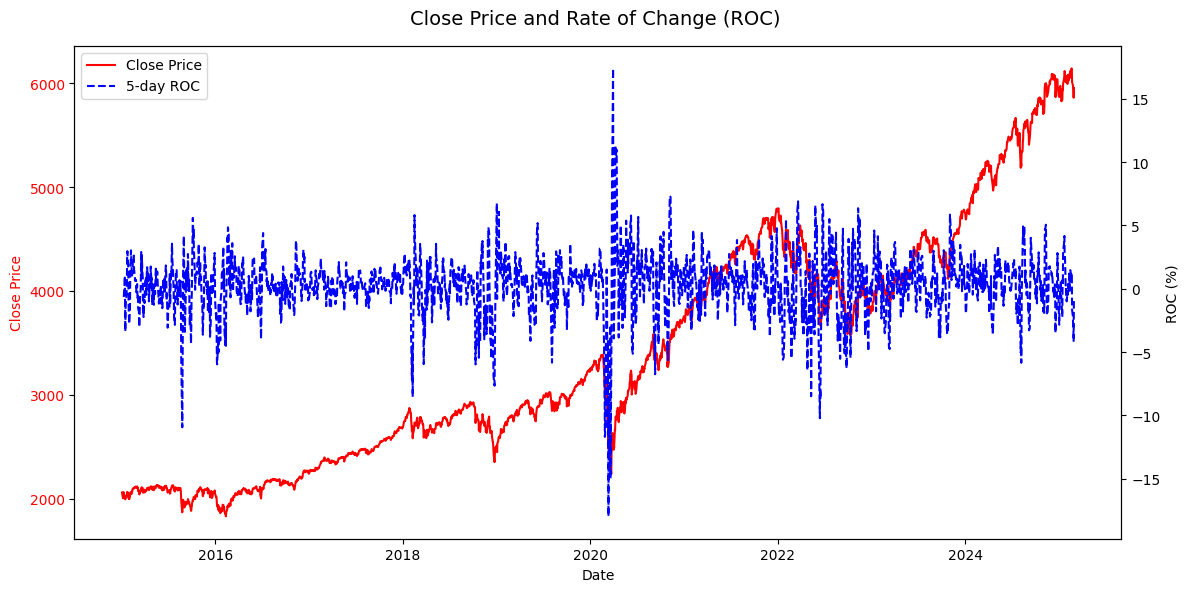

In [ ]:
# @title
# Create a figure and axis object
fig, ax_price = plt.subplots(figsize=(12, 6))

# Plot the Close price on the primary y-axis
ax_price.plot(stock.index, stock['close'], color='red', label='Close Price')
ax_price.set_xlabel('Date')
ax_price.set_ylabel('Close Price', color='red')
ax_price.tick_params(axis='y', labelcolor='red')

# Create a secondary y-axis for ROC
ax_roc = ax_price.twinx()
ax_roc.plot(stock.index, stock['ROC_5d'], color='blue', label='5-day ROC', linestyle='--')
ax_roc.set_ylabel('ROC (%)', color='black')
ax_roc.tick_params(axis='y', labelcolor='black')

# Title and legend
fig.suptitle('Close Price and Rate of Change (ROC)', fontsize=14)
lines_price, labels_price = ax_price.get_legend_handles_labels()
lines_roc, labels_roc = ax_roc.get_legend_handles_labels()
ax_price.legend(lines_price + lines_roc, labels_price + labels_roc, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

**(4) On‑Balance Volume (OBV)**

https://www.investopedia.com/terms/o/onbalancevolume.asp

OBV is a running (cumulative) total that adds the day’s volume when price closes higher than the previous close and subtracts it when the price closes lower.

**OBV condenses two market truths into one line:**

1. **Price** tells you *where* the market is going.  
2. **Volume** tells you *how strongly* it’s going there.

When those two move together, the story is consistent.  
When they diverge, the story is changing — and that’s where opportunities (or warnings) arise.

Why it matters:

On-Balance Volume (OBV) tracks buying and selling pressure by combining price movement and volume, helping confirm trends or warn of potential reversals before prices move.

In [ ]:
def calculate_obv(df: pd.DataFrame, price_col: str = 'close', volume_col: str = 'volume') -> pd.DataFrame:

    direction = np.sign(df[price_col].diff()).fillna(0)
    signed_vol = direction * df[volume_col]

    df['daily_price_direction'] = direction
    df['obv'] = signed_vol.cumsum()

    return df

In [ ]:
stock = calculate_obv(stock, price_col='close', volume_col='volume')

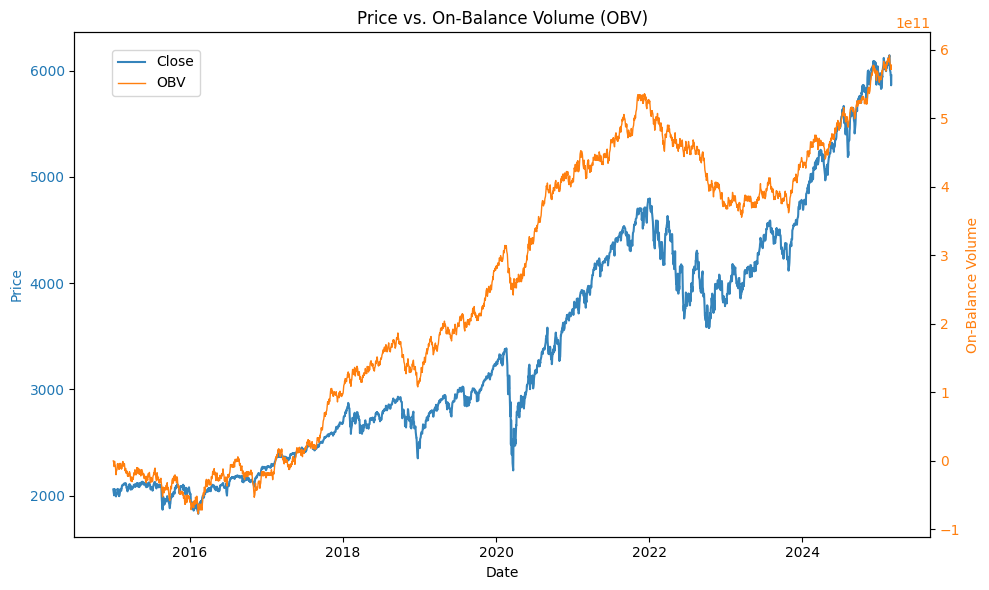

In [ ]:
# @title
stock = stock.sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

# primary axis → closing price
ax1.plot(stock.index, stock['close'], label='Close', linewidth=1.5, alpha=0.9)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# secondary axis → OBV
ax2 = ax1.twinx()
ax2.plot(stock.index, stock['obv'], label='OBV', color='tab:orange', linewidth=1)
ax2.set_ylabel('On‑Balance Volume', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# title & legend
plt.title('Price vs. On‑Balance Volume (OBV)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.11, 0.92))

plt.show()

**(5) VWAP Deviation**

https://corporatefinanceinstitute.com/resources/career-map/sell-side/capital-markets/volume-weighted-adjusted-price-vwap/

considered as a better tool than moving average

**Volume-Weighted Average Price (VWAP)** measures the average price of a stock, weighted by volume throughout the trading day.
It helps traders see the "true" average price at which most trades occurred, balancing both price and volume.

Why it matters:

VWAP shows whether buyers or sellers are in control:

* Price above VWAP → buyers are strong.

* Price below VWAP → sellers dominate.

It helps traders time entries and exits more smartly!

In [ ]:
# Function to calculate VWAP and VWAP Deviation
def calculate_vwap(stock):
    # Cumulative sum of price * volume and volume
    stock['cum_price_volume'] = (stock['close'] * stock['volume']).cumsum()
    stock['cum_volume'] = stock['volume'].cumsum()

    # Calculate VWAP
    stock['VWAP'] = stock['cum_price_volume'] / stock['cum_volume']

    # Calculate VWAP Deviation (percentage deviation from VWAP)
    stock['VWAP_deviation'] = ((stock['close'] - stock['VWAP']) / stock['VWAP']) * 100

    return stock

In [ ]:
stock = calculate_vwap(stock)

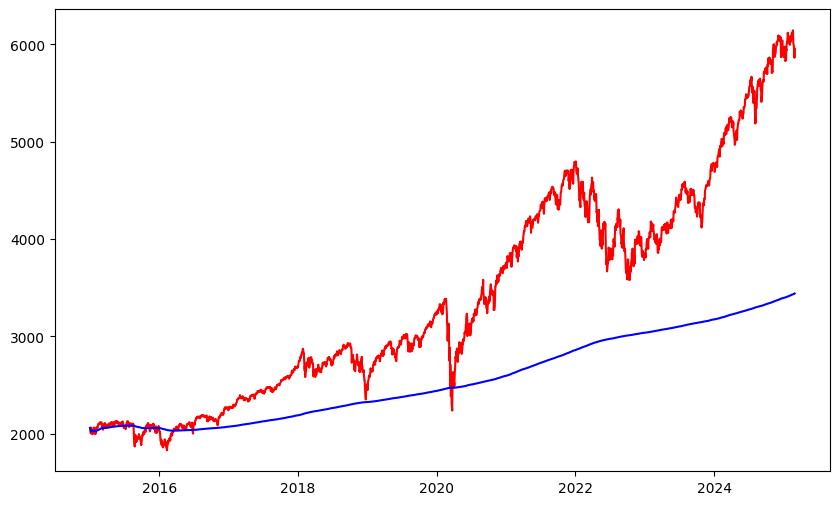

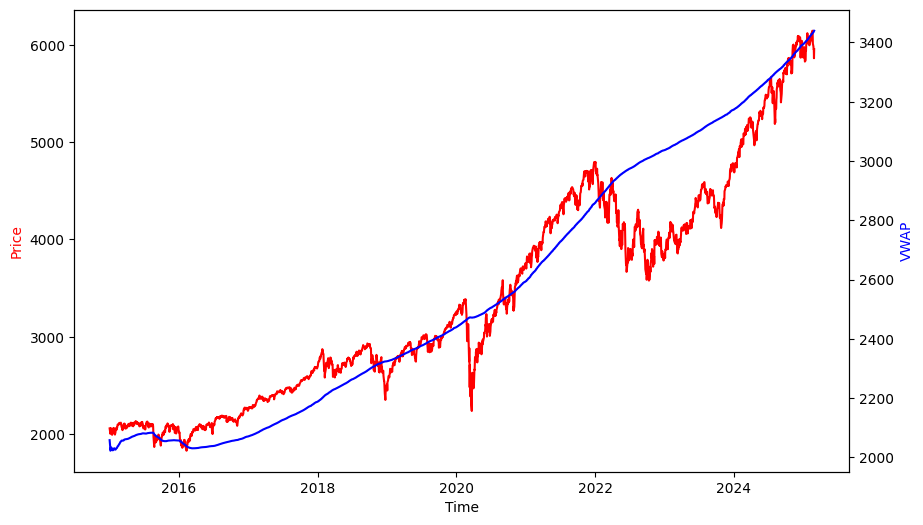

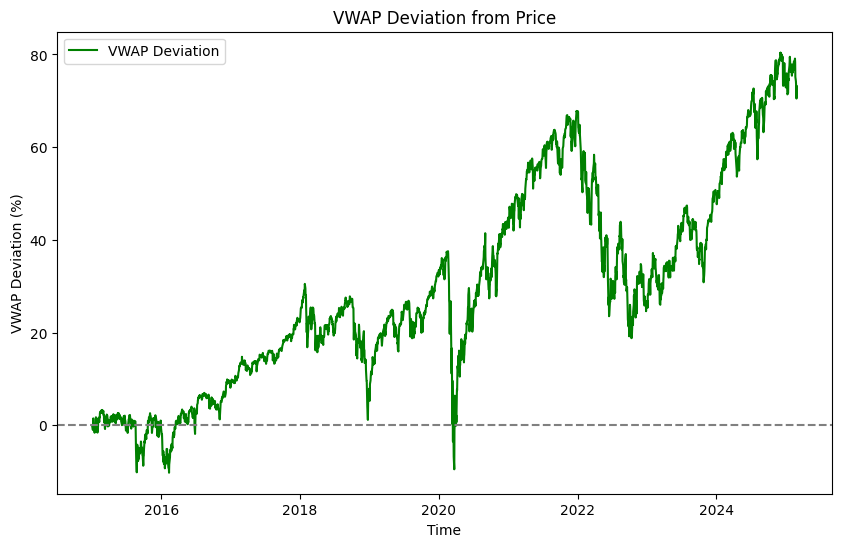

In [ ]:
# @title
plt.figure(figsize=(10, 6))

# Plotting Close price and VWAP
plt.plot(stock.index, stock['close'], label='Close Price', color='red')
plt.plot(stock.index, stock['VWAP'], label='VWAP', color='blue')

# Show VWAP Deviation as a secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(stock.index, stock['close'], label='Close Price', color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color='red')

ax2 = ax1.twinx()
ax2.plot(stock.index, stock['VWAP'], label='VWAP', color='blue')
ax2.set_ylabel('VWAP', color='blue')

# Optional: plot the VWAP deviation
plt.figure(figsize=(10, 6))
plt.plot(stock.index, stock['VWAP_deviation'], label='VWAP Deviation', color='green')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Time')
plt.ylabel('VWAP Deviation (%)')
plt.title('VWAP Deviation from Price')
plt.legend()
plt.show()

**(6) Close Location Value (CLV)**

https://www.investopedia.com/articles/trading/08/accumulation-distribution-line.asp

**Close Location Value (CLV)** measures where the closing price falls within the day’s high-low range.
A close near the high suggests strong buying pressure; a close near the low signals selling pressure.

Why it matters?

CLV shows intraday sentiment:
* Close near high → bulls (buyers) are stronger.
* Close near low → bears (sellers) are stronger.

In [ ]:
def calculate_clv(df):
    # Ensure 'high' and 'low' columns are not equal to avoid division by zero
    df['CLV'] = ((df['close'] - df['low']) / (df['high'] - df['low'])) * 1
    return df

In [ ]:
stock = calculate_clv(stock)

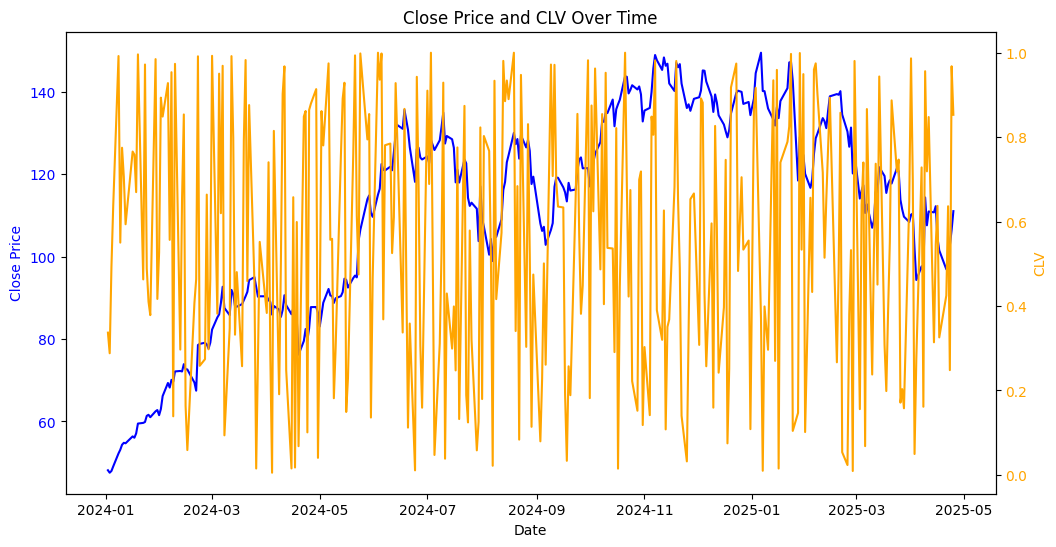

In [ ]:
# @title
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'close' on the primary y-axis
ax1.plot(stock.index, stock['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'CLV'
ax2 = ax1.twinx()
ax2.plot(stock.index, stock['CLV'], color='orange', label='CLV')
ax2.set_ylabel('CLV', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title
plt.title('Close Price and CLV Over Time')

# Show plot
plt.show()


**(7) S&P500 vs. Nasdaq‑100**

Comparing a stock’s price to the Nasdaq-100 shows whether it’s outperforming or underperforming its main peer group (tech-heavy index).

In [ ]:
def calculate_relative_strength(df: pd.DataFrame, stock_col: str = 'close', benchmark_col: str = '^IXIC') -> pd.DataFrame:
    df['relative_strength_nasdaq'] = df[stock_col] / df[benchmark_col]
    df['relative_strength_nasdaq_norm'] = df['relative_strength_nasdaq'] / df['relative_strength_nasdaq'].iloc[0] - 1
    df[f'{stock_col}_norm'] = df[stock_col] / df[stock_col].iloc[0] - 1
    df[f'{benchmark_col}_norm'] = df[benchmark_col] / df[benchmark_col].iloc[0] - 1
    return df


In [ ]:
stock = calculate_relative_strength(stock, stock_col='close', benchmark_col='^IXIC')

In [ ]:
stock.columns

Index(['close', 'high', 'low', 'open', 'volume', 'daily_volatility',
       'daily_movement', 'ticker', '^VIX', '^IXIC', '^IRX', '^FVX', '^TNX',
       '^TYX', 'CL=F', 'DX-Y.NYB', 'VIX_pct_change', 'VIX_lag1', 'VIX_lag2',
       'Date', 'M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS', 'UMCSENT', 'Close_MA5',
       'Close_MA10', 'Close_MA20', 'Close_MA50', 'Close_MA200', 'RSI14',
       'ROC_5d', 'daily_price_direction', 'obv', 'cum_price_volume',
       'cum_volume', 'VWAP', 'VWAP_deviation', 'CLV',
       'relative_strength_nasdaq', 'relative_strength_nasdaq_norm',
       'close_norm', '^IXIC_norm'],
      dtype='object')

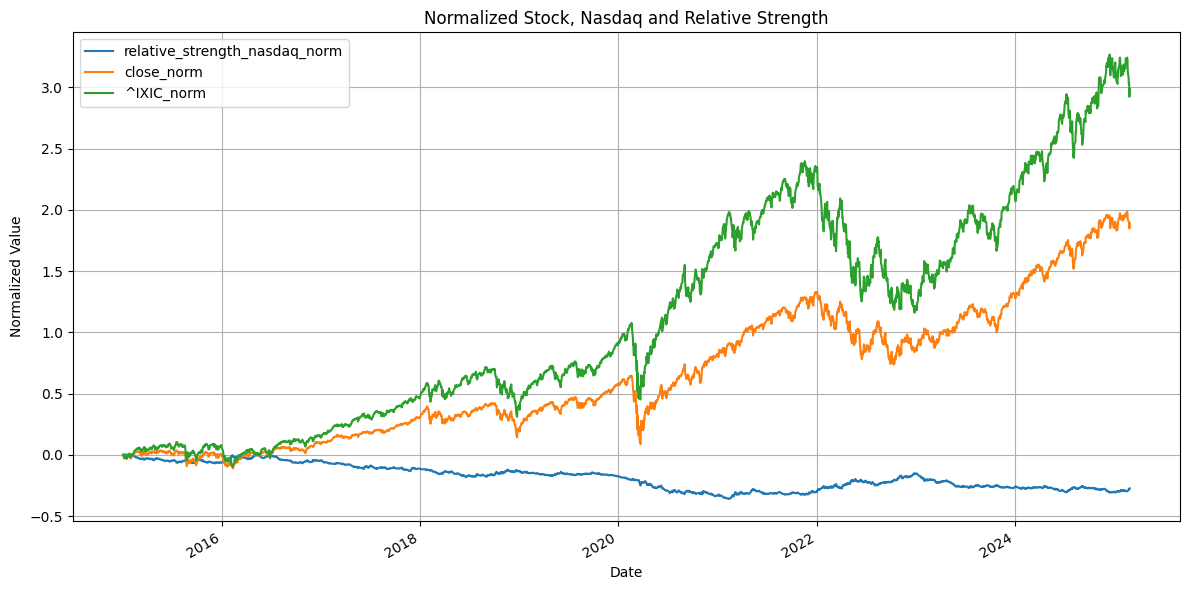

In [ ]:
# @title
stock[['relative_strength_nasdaq_norm', 'close_norm', '^IXIC_norm']].plot(figsize=(12, 6))
plt.title('Normalized Stock, Nasdaq and Relative Strength')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**(8) Implied Volatility (VIX level)**

https://www.investopedia.com/terms/v/vix.asp

The **VIX** (Volatility Index) is a measure of how much people expect the stock market to go up or down in the next 30 days. It’s often called the “fear gauge” because when it’s high, it means there’s a lot of uncertainty and fear in the market. When the VIX is low, it suggests people are feeling more confident, and the market is likely to stay stable.

- **High VIX** = High uncertainty or fear.
- **Low VIX** = Low uncertainty or more confidence.

It’s based on the prices of options in the S&P 500 index, so it reflects how much people are willing to pay for protection against big market swings.

### VIX index levels interpretastions
| VIX level | What it suggests |
|-----------|------------------|
| **~10–15** | Markets feel calm; traders expect small daily moves. |
| **~20**    | “Normal” choppiness. |
| **30+**    | Growing worry; bigger swings likely. |
| **40‑80**  | Crisis mode (e.g., 2008, March 2020). |

### Key point  
The VIX does **not** say which direction stocks will move—only how bumpy the ride is expected to be.

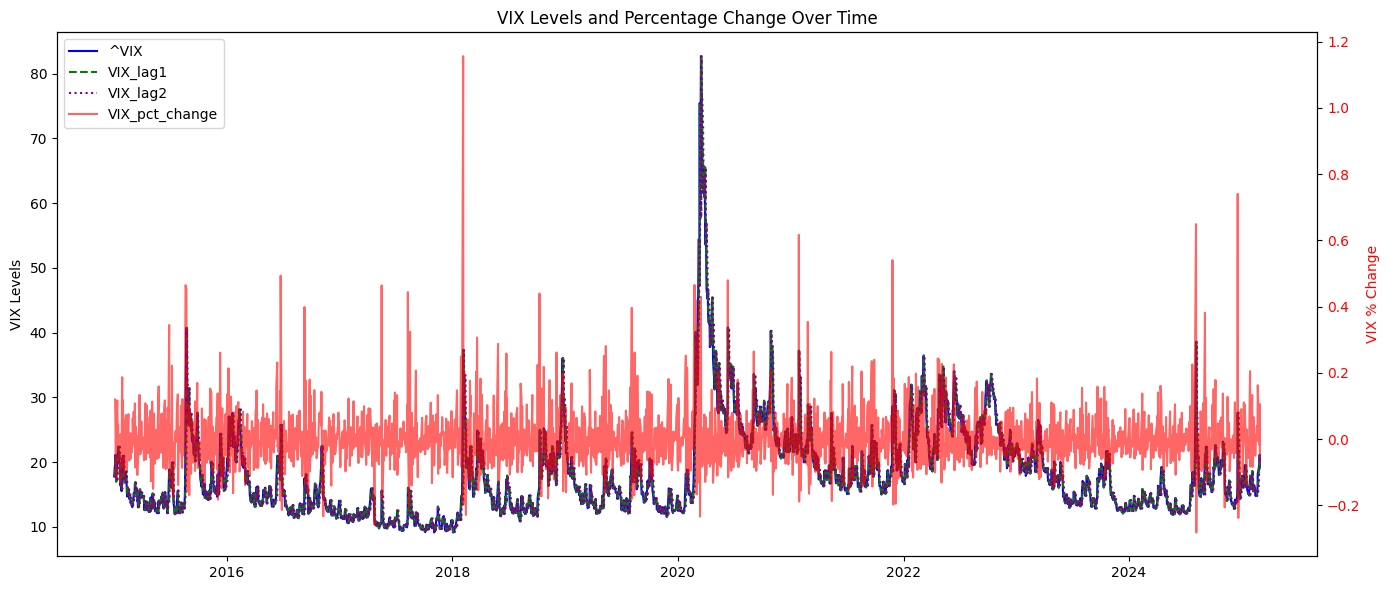

In [ ]:
# @title
fig, ax1 = plt.subplots(figsize=(14, 6))

# Primary y-axis
ax1.plot(stock['^VIX'], label='^VIX', color='blue')
ax1.plot(stock['VIX_lag1'], label='VIX_lag1', color='green', linestyle='--')
ax1.plot(stock['VIX_lag2'], label='VIX_lag2', color='purple', linestyle=':')
ax1.set_ylabel('VIX Levels', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Secondary y-axis
ax2 = ax1.twinx()
ax2.plot(stock['VIX_pct_change'], label='VIX_pct_change', color='red', alpha=0.6)
ax2.set_ylabel('VIX % Change', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('VIX Levels and Percentage Change Over Time')
plt.tight_layout()
plt.show()



---



In [ ]:
tickers2 = [
    ticker
]

In [ ]:
start2 = "2015-01-01"
end2 = "2025-03-01"

In [ ]:

def pipeline_all(ticker, start2, end2):

    stock = get_stock_price(ticker, start=start2, end=end2)
    stock = add_mv(stock)
    stock = add_rsi(stock)
    stock = add_roc(stock, 'close', 5)
    stock = calculate_obv(stock, price_col='close', volume_col='volume')
    stock = calculate_vwap(stock)
    stock = calculate_clv(stock)
    stock = calculate_relative_strength(stock, stock_col='close', benchmark_col='^IXIC')

    return stock


In [ ]:
import time

list_stocks_dfs = [] # initialize an empty list

for t in tickers2:
    r = pipeline_all(t, start2, end2)
    globals()[t] = r
    time.sleep(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


retriving FRED


In [ ]:
dfs = []

for ticker in tickers2:
    dfs.append(globals()[ticker])

master_df = pd.concat(dfs, axis=0, ignore_index=True)

In [ ]:
master_df

,close,high,low,open,volume,daily_volatility,daily_movement,ticker,^VIX,^IXIC,...,obv,cum_price_volume,cum_volume,VWAP,VWAP_deviation,CLV,relative_strength_nasdaq,relative_strength_nasdaq_norm,close_norm,^IXIC_norm
0,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,26.320068,-0.699951,^GSPC,17.790001,4726.810059,...,0.000000e+00,5.575046e+12,2708700000,2058.199951,0.000000,0.462002,0.435431,0.000000,0.000000,0.000000
1,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,37.099976,-33.859985,^GSPC,19.920000,4652.569824,...,-3.799120e+09,1.325147e+13,6507820000,2036.238238,-0.768981,0.087331,0.434293,-0.002613,-0.018278,-0.015706
2,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,37.810059,-19.540039,^GSPC,21.120001,4592.740234,...,-8.259230e+09,2.218333e+13,10967930000,2022.563305,-0.986536,0.268977,0.436038,0.001394,-0.027009,-0.028364
3,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,24.059937,20.349976,^GSPC,19.309999,4650.470215,...,-4.453750e+09,2.989285e+13,14773410000,2023.422810,0.122427,0.845803,0.435633,0.000465,-0.015693,-0.016150
4,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,33.470093,31.529907,^GSPC,17.010000,4736.189941,...,-5.197400e+08,3.800533e+13,18707420000,2031.564681,1.505008,0.942032,0.435401,-0.000070,0.001914,0.001984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,5983.250000,6043.649902,5977.830078,6026.689941,4990120000,65.819824,-43.439941,^GSPC,18.980000,19286.929688,...,5.766252e+11,3.517061e+16,10240908440000,3434.324882,74.219103,0.082345,0.310223,-0.287550,1.907030,3.080327
2551,5955.250000,5992.649902,5908.490234,5982.729980,5374690000,84.159668,-27.479980,^GSPC,19.430000,19026.390625,...,5.712506e+11,3.520261e+16,10246283130000,3435.647234,73.337063,0.555608,0.312999,-0.281173,1.893426,3.025207
2552,5956.060059,6009.819824,5932.689941,5970.870117,4869580000,77.129883,-14.810059,^GSPC,19.100000,19075.259766,...,5.761201e+11,3.523162e+16,10251152710000,3436.844499,73.300249,0.302997,0.312240,-0.282917,1.893820,3.035546
2553,5861.569824,5993.689941,5858.779785,5981.879883,5057680000,134.910156,-120.310059,^GSPC,21.129999,18544.419922,...,5.710624e+11,3.526126e+16,10256210390000,3438.040212,70.491602,0.020681,0.316083,-0.274093,1.847911,2.923242




---



### **(2) EXPLORATORY DATA ANALYSIS**



---



In [1]:
import pandas as pd
from google.colab import files
import numpy as np

In [2]:
uploaded = files.upload()
df = pd.read_csv('master_df_sp500.csv')
df.head()

Saving master_df_sp500.csv to master_df_sp500.csv


,close,high,low,open,volume,daily_volatility,daily_movement,ticker,^VIX,^IXIC,...,obv,cum_price_volume,cum_volume,VWAP,VWAP_deviation,CLV,relative_strength_nasdaq,relative_strength_nasdaq_norm,close_norm,^IXIC_norm
0,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,26.320068,-0.699951,^GSPC,17.790001,4726.810059,...,0.000000e+00,5.575046e+12,2708700000,2058.199951,0.000000,0.462002,0.435431,0.000000,0.000000,0.000000
1,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,37.099976,-33.859985,^GSPC,19.920000,4652.569824,...,-3.799120e+09,1.325147e+13,6507820000,2036.238238,-0.768981,0.087331,0.434293,-0.002613,-0.018278,-0.015706
2,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,37.810059,-19.540039,^GSPC,21.120001,4592.740234,...,-8.259230e+09,2.218333e+13,10967930000,2022.563305,-0.986536,0.268977,0.436038,0.001394,-0.027009,-0.028364
3,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,24.059937,20.349976,^GSPC,19.309999,4650.470215,...,-4.453750e+09,2.989285e+13,14773410000,2023.422810,0.122427,0.845803,0.435633,0.000465,-0.015693,-0.016150
4,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,33.470093,31.529907,^GSPC,17.010000,4736.189941,...,-5.197400e+08,3.800533e+13,18707420000,2031.564681,1.505008,0.942032,0.435401,-0.000070,0.001914,0.001984


**Data Sources**:
1. Yahoo Finance (yfinance API): share price, intrest rates,
2. US Federal Reselves Bank (fredapi API): macroeconomic factors

**Time range for gathered data:**
Over 9 years, 01.01.2016 - 27.02.2025



---



### **Data Flow**

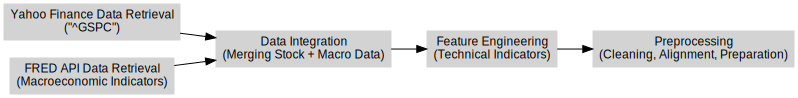

In [3]:
# @title
# Install graphviz if needed
!pip install graphviz

from graphviz import Digraph

# Create Digraph object
dot = Digraph(comment='Data Flow for Project')

# Set global graph attributes
dot.attr(rankdir='LR',  # Left to Right layout
         fontname='Helvetica')

# Set node attributes
dot.attr('node', shape='box', style='filled', color='lightgrey', fontname='Helvetica', fontsize='12')

# Define nodes
dot.node('A', 'Yahoo Finance Data Retrieval\n("^GSPC")')
dot.node('B', 'FRED API Data Retrieval\n(Macroeconomic Indicators)')
dot.node('C', 'Data Integration\n(Merging Stock + Macro Data)')
dot.node('D', 'Feature Engineering\n(Technical Indicators)')
dot.node('E', 'Preprocessing\n(Cleaning, Alignment, Preparation)')

# Define edges
dot.edge('A', 'C')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')

# Render and display
dot.render('data_flow_chart', format='png', view=True)
dot

---



### **S&P 500 Valuation Price Development Over Time**

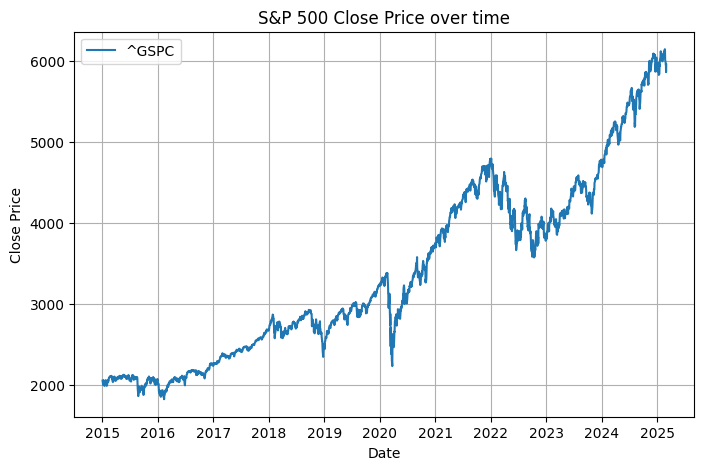

In [4]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Pivot the DataFrame
pivot_df = df.pivot(index='Date', columns='ticker', values='close')
pivot_df = pivot_df.sort_index()

# Create the plot
plt.figure(figsize=(8, 5))
for ticker in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[ticker], label=ticker)

# Format x-axis to show only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Title and labels
plt.title('S&P 500 Close Price over time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()



---



### **S&P 500 Index Returns**

**PRICE AT THE END OF EACH YEAR**

In [5]:
# Pivot the data
closing_price_pivot = df.pivot(index='Date', columns='ticker', values='close')

# Make sure Date is datetime and sorted
closing_price_pivot.index = pd.to_datetime(closing_price_pivot.index)
closing_price_pivot = closing_price_pivot.sort_index()

# Resample to yearly frequency, taking the last available closing price of each year
yearly_closing_prices = closing_price_pivot.resample('YE').last()

# Display the result
yearly_closing_prices

ticker,^GSPC
Date,
2015-12-31,2043.939941
2016-12-31,2238.830078
2017-12-31,2673.610107
2018-12-31,2506.850098
2019-12-31,3230.780029
2020-12-31,3756.070068
2021-12-31,4766.180176
2022-12-31,3839.500000
2023-12-31,4769.830078


**YEARY RETURNS**

In [6]:
# Calculate the yearly returns in percentage
yearly_returns = yearly_closing_prices.pct_change() * 100

# Extract the year from the index
yearly_returns.index = yearly_returns.index.year

# Remove year 2015 from the DataFrame
yearly_returns = yearly_returns[yearly_returns.index != 2015]

# Display the result
yearly_returns


ticker,^GSPC
Date,
2016,9.535023
2017,19.419966
2018,-6.237260
2019,28.878070
2020,16.258923
2021,26.892739
2022,-19.442827
2023,24.230501
2024,23.309002


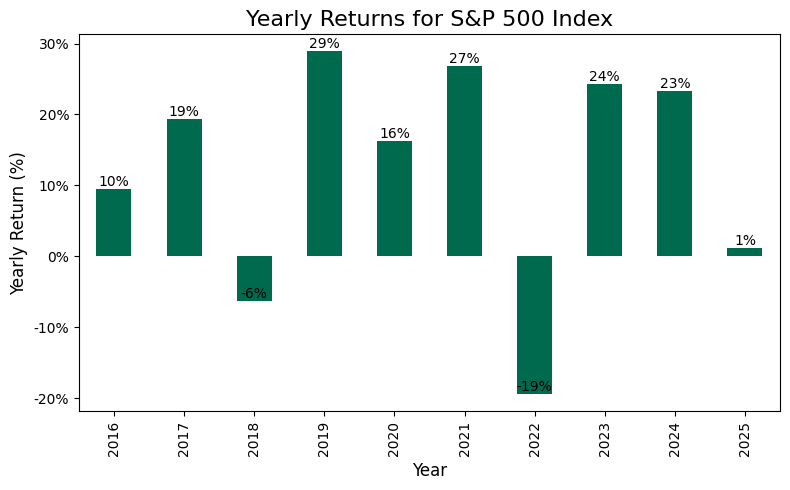

In [7]:
# @title
import matplotlib.pyplot as plt

# Plot the yearly returns as a bar chart with bottle green color
ax = yearly_returns.astype(float).plot(kind='bar', figsize=(8, 5), color='#006A4E', legend=False)

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Add data labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}%',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10, color='black')

# Set the title and labels
plt.title('Yearly Returns for S&P 500 Index', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yearly Return (%)', fontsize=12)

# Improve layout
plt.tight_layout()

# Display the chart
plt.show()


In [8]:
yearly_returns.mean()


,0
ticker,
^GSPC,12.408308


In [9]:
yearly_returns.describe()

ticker,^GSPC
count,10.000000
mean,12.408308
std,15.981914
min,-19.442827
25%,3.312964
50%,17.839444
75%,24.000126
max,28.878070




---



### **Correlation Analysis**

In [10]:
import numpy as np

# Pivot the DataFrame: rows = Dates, columns = Tickers, values = Close prices
pivot_df = df[['Date', 'close', '^VIX', '^IXIC', '^IRX',  '^TNX',
                'CL=F', 'DX-Y.NYB', 'M1SL', 'ROC_5d', 'RSI14','VWAP', 'obv' ]]

# Set 'Date' as the index
pivot_df = pivot_df.set_index('Date')

# Sort by Date just in case
pivot_df = pivot_df.sort_index()

# Calculate daily returns
returns = pivot_df.pct_change().dropna()

# Calculate correlation matrix
correlation_matrix = returns.corr()

# Get the upper triangle of the correlation matrix, excluding the diagonal
average_correlation = np.mean(correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)])

# Print results
print(correlation_matrix)
print(f"Average correlation: {average_correlation:.2f}")

             close      ^VIX     ^IXIC      ^IRX      ^TNX      CL=F  \
close     1.000000 -0.710624  0.946630 -0.040187  0.276651  0.143997   
^VIX     -0.710624  1.000000 -0.693386  0.010343 -0.187286 -0.108595   
^IXIC     0.946630 -0.693386  1.000000 -0.051765  0.199324  0.109317   
^IRX     -0.040187  0.010343 -0.051765  1.000000  0.069978 -0.023133   
^TNX      0.276651 -0.187286  0.199324  0.069978  1.000000  0.109222   
CL=F      0.143997 -0.108595  0.109317 -0.023133  0.109222  1.000000   
DX-Y.NYB -0.114355  0.041647 -0.104972 -0.024685  0.204421 -0.036190   
M1SL     -0.051054  0.019016 -0.048267  0.004869  0.017233  0.014071   
ROC_5d    0.025419 -0.003294  0.008986 -0.004863  0.000150  0.008700   
RSI14     0.708571 -0.637586  0.695706 -0.020677  0.146237  0.078069   
VWAP      0.072126 -0.030292  0.061613 -0.079205  0.068798  0.021332   
obv      -0.004639  0.012115 -0.003247  0.004851 -0.010727 -0.005385   

          DX-Y.NYB      M1SL    ROC_5d     RSI14      VWAP     

<ipython-input-10-184fce8e8842>:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot_df.pct_change().dropna()


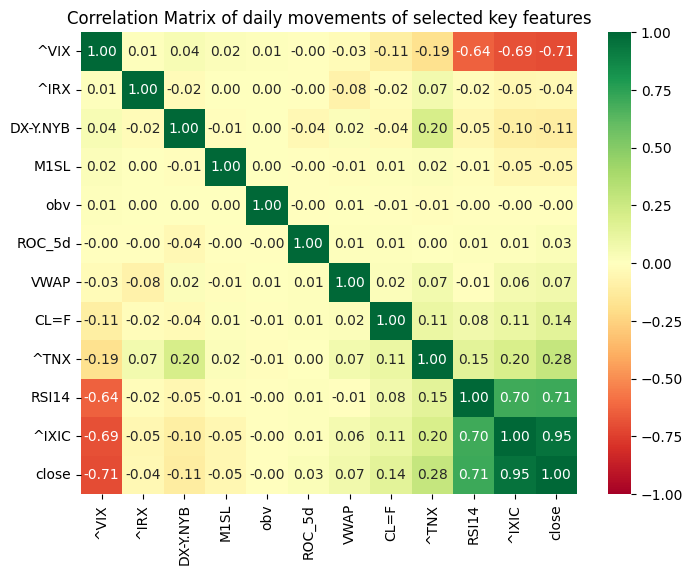

In [11]:
# @title
import seaborn as sns
import matplotlib.pyplot as plt

# First, sort the correlation matrix by average correlation
mean_corr = correlation_matrix.mean().sort_values()

# Reorder rows and columns based on mean_corr
correlation_matrix_sorted = correlation_matrix.loc[mean_corr.index, mean_corr.index]

# Set the size of the plot
plt.figure(figsize=(8, 6))

# Create the heatmap with 2 decimal places
sns.heatmap(correlation_matrix_sorted, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, center=0, fmt='.2f')

# Add title
plt.title('Correlation Matrix of daily movements of selected key features')

# Show the plot
plt.show()


**Features Legend**

| Ticker     | Explanation                        |
|------------|-------------------------------------------|
| `close`    | Closing price of S&P500          |
| `^VIX`     | Volatility Index, market fear gauge       |
| `^IXIC`    | NASDAQ Composite Index, tech stocks       |
| `^IRX`     | 13-week Treasury Bill yield               |
| `^TNX`     | 10-year Treasury Yield                    |
| `CL=F`     | Crude Oil futures price                   |
| `DX-Y.NYB` | U.S. Dollar Index (USD strength)          |
| `M1SL`     | U.S. Money Supply (M1)                    |
| `ROC_5d`   | 5-day Rate of Change in price             |
| `RSI14`    | 14-day Relative Strength Index (momentum) |
| `VWAP`     | Volume Weighted Average Price             |
| `obv`      | On-Balance Volume (volume momentum)       |



---



### **Daily Price Changes statistics**

In [15]:
df['Date'] = pd.to_datetime(df['Date'])

# Limit data to the specified date range
df_filtered = df[(df['Date'] >= '2016-01-01') & (df['Date'] <= '2025-02-27')]

df_filtered['Daily_Pct_Change'] = df_filtered['close'].pct_change() * 100  # Multiplied by 100 to get percentage

df_filtered = df_filtered.dropna()

print(df_filtered[['Date', 'close', 'Daily_Pct_Change']])

           Date        close  Daily_Pct_Change
253  2016-01-05  2016.709961          0.201223
254  2016-01-06  1990.260010         -1.311540
255  2016-01-07  1943.089966         -2.370044
256  2016-01-08  1922.030029         -1.083837
257  2016-01-11  1923.670044          0.085327
...         ...          ...               ...
2549 2025-02-21  6013.129883         -1.706413
2550 2025-02-24  5983.250000         -0.496911
2551 2025-02-25  5955.250000         -0.467973
2552 2025-02-26  5956.060059          0.013602
2553 2025-02-27  5861.569824         -1.586455

[2299 rows x 3 columns]


<ipython-input-15-7c0314d8cca2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Daily_Pct_Change'] = df_filtered['close'].pct_change() * 100  # Multiplied by 100 to get percentage


In [16]:
df_filtered[['Daily_Pct_Change']].describe()

,Daily_Pct_Change
count,2299.000000
mean,0.052823
std,1.133738
min,-11.984055
25%,-0.366196
50%,0.071153
75%,0.580972
max,9.382774


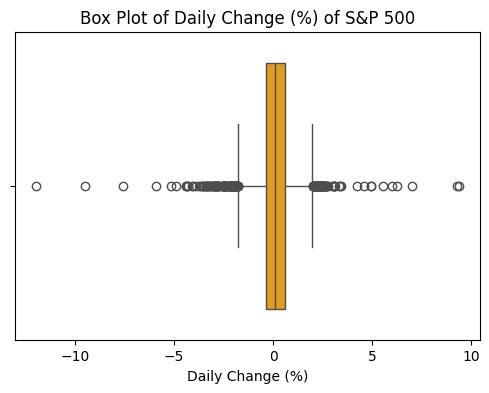

In [18]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_filtered is already loaded and contains the 'Daily Change (%)' column
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_filtered, x='Daily_Pct_Change', color='orange')
plt.title('Box Plot of Daily Change (%) of S&P 500')
plt.xlabel('Daily Change (%)')
plt.show()

**Count days by valuation direction**

In [20]:
# Counting the number of positive and negative 'Daily Change (%)' days
positive_days = df_filtered[df_filtered['Daily_Pct_Change'] > 0].shape[0]
negative_days = df_filtered[df_filtered['Daily_Pct_Change'] < 0].shape[0]

# Total number of days
total_days = df_filtered.shape[0]

# Calculating the percentages
positive_percentage = (positive_days / total_days) * 100
negative_percentage = (negative_days / total_days) * 100

positive_days, negative_days, positive_percentage, negative_percentage


(1252, 1046, 54.45846020008699, 45.49804262722923)



---



### **(3) S&P 500 NEXT DAY VALUATION PREDICTION USING RANDOM FOREST**



---



In [21]:
import pandas as pd
from google.colab import files
# 0. Imports
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [22]:
import pandas as pd
uploaded = files.upload()
df = pd.read_csv('master_df_sp500.csv')
df.head()

Saving master_df_sp500.csv to master_df_sp500 (1).csv


,close,high,low,open,volume,daily_volatility,daily_movement,ticker,^VIX,^IXIC,...,obv,cum_price_volume,cum_volume,VWAP,VWAP_deviation,CLV,relative_strength_nasdaq,relative_strength_nasdaq_norm,close_norm,^IXIC_norm
0,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,26.320068,-0.699951,^GSPC,17.790001,4726.810059,...,0.000000e+00,5.575046e+12,2708700000,2058.199951,0.000000,0.462002,0.435431,0.000000,0.000000,0.000000
1,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,37.099976,-33.859985,^GSPC,19.920000,4652.569824,...,-3.799120e+09,1.325147e+13,6507820000,2036.238238,-0.768981,0.087331,0.434293,-0.002613,-0.018278,-0.015706
2,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,37.810059,-19.540039,^GSPC,21.120001,4592.740234,...,-8.259230e+09,2.218333e+13,10967930000,2022.563305,-0.986536,0.268977,0.436038,0.001394,-0.027009,-0.028364
3,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,24.059937,20.349976,^GSPC,19.309999,4650.470215,...,-4.453750e+09,2.989285e+13,14773410000,2023.422810,0.122427,0.845803,0.435633,0.000465,-0.015693,-0.016150
4,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,33.470093,31.529907,^GSPC,17.010000,4736.189941,...,-5.197400e+08,3.800533e+13,18707420000,2031.564681,1.505008,0.942032,0.435401,-0.000070,0.001914,0.001984


In [23]:
df['Date'] = pd.to_datetime(df['Date'])

In [24]:
df = df.set_index("Date")

In [25]:
sp500 = df[['close', 'high', 'low', 'open', 'volume', 'daily_volatility',
       'daily_movement', 'ticker', '^VIX', '^IXIC', '^FVX', '^TNX',
       '^TYX', 'CL=F', 'DX-Y.NYB', 'VIX_pct_change', 'VIX_lag1', 'VIX_lag2',
       'M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS', 'UMCSENT', 'Close_MA5',
       'Close_MA10', 'Close_MA20', 'Close_MA50', 'Close_MA200', 'RSI14',
       'ROC_5d', 'daily_price_direction', 'obv', 'VWAP', 'VWAP_deviation', 'CLV',
       'relative_strength_nasdaq', 'relative_strength_nasdaq_norm',
       'close_norm', '^IXIC_norm']].copy()

sp500 = sp500.round(2)

CHANGE KEY FEATURES FROM ABSOLUTE TO RELATIVE FOR RANDOM FOREST

In [26]:
import numpy as np

features_to_pct_change = [
    'open', 'high', 'low', 'volume',
    'daily_volatility', 'daily_movement',
    '^VIX', '^IXIC', '^FVX', '^TNX', '^TYX',
    'CL=F', 'DX-Y.NYB', 'Close_MA5',
       'Close_MA10', 'Close_MA20', 'Close_MA50', 'Close_MA200'
]

sp500[features_to_pct_change] = sp500[features_to_pct_change].pct_change()

# Replace inf/-inf with NaN
sp500[features_to_pct_change] = sp500[features_to_pct_change].replace([np.inf, -np.inf], np.nan)

# CHECK: Count NaNs per feature
nan_counts = sp500[features_to_pct_change].isna().sum()
print("NaN counts per feature after pct_change():")
print(nan_counts)

# Drop rows with any NaN
sp500.replace([np.inf, -np.inf], np.nan, inplace=True)
sp500 = sp500.dropna()


NaN counts per feature after pct_change():
open                1
high                1
low                 1
volume              1
daily_volatility    1
daily_movement      2
^VIX                1
^IXIC               1
^FVX                1
^TNX                1
^TYX                1
CL=F                1
DX-Y.NYB            1
Close_MA5           1
Close_MA10          1
Close_MA20          1
Close_MA50          1
Close_MA200         1
dtype: int64


<ipython-input-26-8d5de834f370>:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp500[features_to_pct_change] = sp500[features_to_pct_change].pct_change()


In [27]:
# CHECK: Count NaNs per feature
nan_counts = sp500[features_to_pct_change].isna().sum()
print("NaN counts per feature after pct_change():")
print(nan_counts)

NaN counts per feature after pct_change():
open                0
high                0
low                 0
volume              0
daily_volatility    0
daily_movement      0
^VIX                0
^IXIC               0
^FVX                0
^TNX                0
^TYX                0
CL=F                0
DX-Y.NYB            0
Close_MA5           0
Close_MA10          0
Close_MA20          0
Close_MA50          0
Close_MA200         0
dtype: int64


In [28]:
print("NaNs per feature:\n", sp500.isna().sum())

NaNs per feature:
 close                            0
high                             0
low                              0
open                             0
volume                           0
daily_volatility                 0
daily_movement                   0
ticker                           0
^VIX                             0
^IXIC                            0
^FVX                             0
^TNX                             0
^TYX                             0
CL=F                             0
DX-Y.NYB                         0
VIX_pct_change                   0
VIX_lag1                         0
VIX_lag2                         0
M1SL                             0
M2SL                             0
CPIAUCSL                         0
PAYEMS                           0
UMCSENT                          0
Close_MA5                        0
Close_MA10                       0
Close_MA20                       0
Close_MA50                       0
Close_MA200                      0
R

In [30]:
# Only select numeric columns
numeric_cols = sp500.select_dtypes(include=[np.number])

# Now safely check for inf
inf_counts = np.isinf(numeric_cols).sum()

print("Infs per feature:\n", inf_counts)

Infs per feature:
 close                            0
high                             0
low                              0
open                             0
volume                           0
daily_volatility                 0
daily_movement                   0
^VIX                             0
^IXIC                            0
^FVX                             0
^TNX                             0
^TYX                             0
CL=F                             0
DX-Y.NYB                         0
VIX_pct_change                   0
VIX_lag1                         0
VIX_lag2                         0
M1SL                             0
M2SL                             0
CPIAUCSL                         0
PAYEMS                           0
UMCSENT                          0
Close_MA5                        0
Close_MA10                       0
Close_MA20                       0
Close_MA50                       0
Close_MA200                      0
RSI14                            0
R

In [31]:
# Create Target: Predict Tomorrow's Change (not Close)

sp500["Target_Change_pct"] = ((sp500["close"].shift(-1) / sp500["close"]) - 1).round(5)


In [32]:
# Only select numeric columns
numeric_cols = sp500.select_dtypes(include=[np.number])

# Now safely check for inf
inf_counts = np.isinf(numeric_cols).sum()

print("Infs per feature:\n", inf_counts)

Infs per feature:
 close                            0
high                             0
low                              0
open                             0
volume                           0
daily_volatility                 0
daily_movement                   0
^VIX                             0
^IXIC                            0
^FVX                             0
^TNX                             0
^TYX                             0
CL=F                             0
DX-Y.NYB                         0
VIX_pct_change                   0
VIX_lag1                         0
VIX_lag2                         0
M1SL                             0
M2SL                             0
CPIAUCSL                         0
PAYEMS                           0
UMCSENT                          0
Close_MA5                        0
Close_MA10                       0
Close_MA20                       0
Close_MA50                       0
Close_MA200                      0
RSI14                            0
R

Mean Absolute Error (MAE): 36.25
Root Mean Squared Error (RMSE): 47.45
R² Score: 0.98
            Tomorrow  Predicted_Close_pct
Date                                     
2024-03-01   5130.95          5144.339208
2024-03-04   5078.65          5130.345061
2024-03-05   5104.76          5088.970325
2024-03-06   5157.36          5116.865258
2024-03-07   5123.69          5166.223611
2024-03-08   5117.94          5133.955142
2024-03-11   5175.27          5139.056109
2024-03-12   5165.31          5189.135756
2024-03-13   5150.48          5165.836862
2024-03-14   5117.09          5151.723498


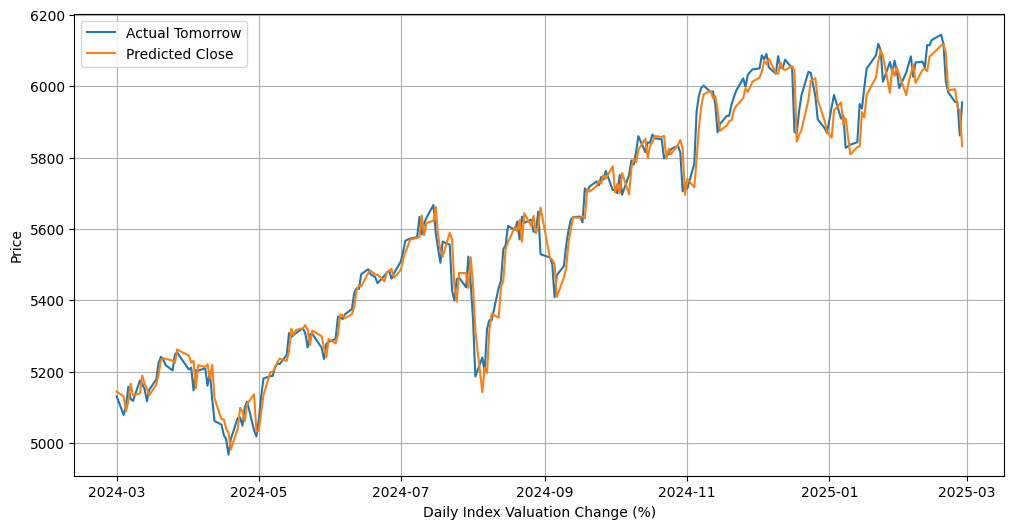

In [33]:
# Train-Test Split (fixed rows for test - roughly 1 year)
train = sp500.iloc[:-250]
test = sp500.iloc[-250:]


predictors = [
    'high', 'low', 'open', 'volume',
    'daily_volatility', 'daily_movement', '^VIX', '^IXIC', '^FVX', '^TNX',
    '^TYX', 'CL=F', 'DX-Y.NYB',
    'M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS', 'UMCSENT', 'Close_MA5',
    'Close_MA10', 'Close_MA20', 'Close_MA50', 'Close_MA200', 'RSI14',
    'ROC_5d', 'daily_price_direction', 'obv', 'VWAP', 'CLV'
]

# Modeling: RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=300,
    random_state=1
)

sp500 = sp500.round(2)

model.fit(train[predictors], train["Target_Change_pct"])

predicted_change_pct = model.predict(test[predictors])

test['Predicted_Close_pct'] = test['close'] + (test['close'] * predicted_change_pct)

test['Predicted_Change_pct'] = predicted_change_pct

# For evaluation: true Tomorrow Close
test['Tomorrow'] = test['close'].shift(-1)

test = test.dropna()

# Model Evaluation
mae = mean_absolute_error(test["Tomorrow"], test['Predicted_Close_pct'])
mse = mean_squared_error(test["Tomorrow"], test['Predicted_Close_pct'])
rmse = mse**0.5
r2 = r2_score(test["Tomorrow"], test['Predicted_Close_pct'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Optional: See first few rows
print(test[['Tomorrow', 'Predicted_Close_pct']].head(10))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Tomorrow'], label='Actual Tomorrow')
plt.plot(test.index, test['Predicted_Close_pct'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xlabel('Daily Index Valuation Change (%)')
plt.legend()
plt.grid(True)
plt.show()

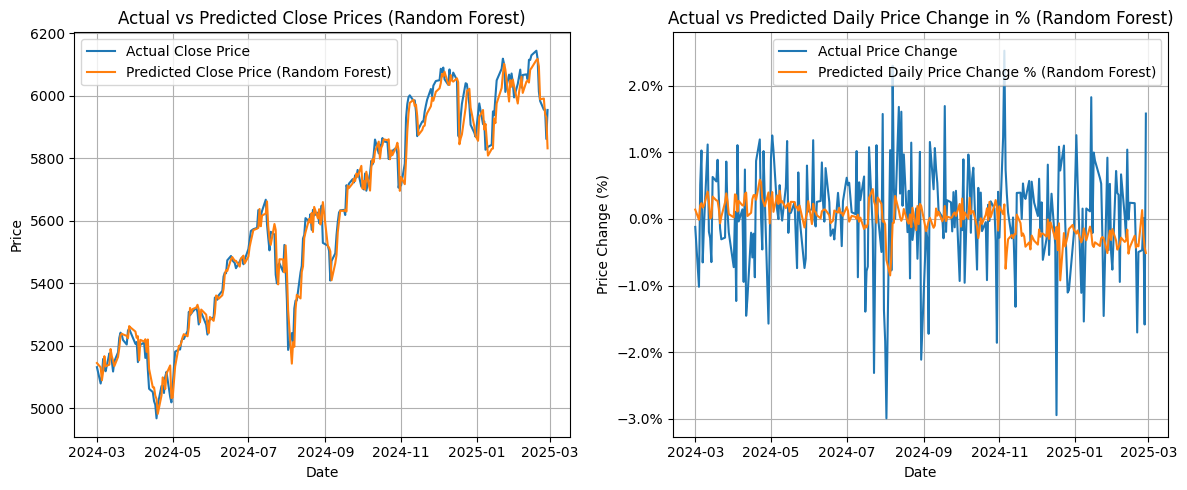

In [34]:
# @title
from matplotlib.ticker import PercentFormatter

# 9. Plotting Side by Side
plt.figure(figsize=(12, 5))  # Wider figure for side-by-side plots

# First plot (XGBoost)
plt.subplot(1, 2, 1)  # (rows=1, columns=2, first plot)
plt.plot(test.index, test['Tomorrow'], label='Actual Close Price')
plt.plot(test.index, test['Predicted_Close_pct'], label='Predicted Close Price (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Prices (Random Forest)')
plt.legend()
plt.grid(True)

# Second plot (XGBoost model)
plt.subplot(1, 2, 2)  # (rows=1, columns=2, second plot)
plt.plot(test.index, test['Target_Change_pct'], label='Actual Price Change')
plt.plot(test.index, test['Predicted_Change_pct'], label='Predicted Daily Price Change % (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.title('Actual vs Predicted Daily Price Change in % (Random Forest)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Format y-axis as %
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

                  Feature  Importance
0                    high    0.097042
20             Close_MA20    0.068890
21             Close_MA50    0.065850
2                    open    0.062590
7                   ^IXIC    0.060410
19             Close_MA10    0.048284
10                   ^TYX    0.047272
22            Close_MA200    0.038307
6                    ^VIX    0.036884
23                  RSI14    0.036250
12               DX-Y.NYB    0.034328
11                   CL=F    0.033591
8                    ^FVX    0.033240
18              Close_MA5    0.032049
1                     low    0.031280
9                    ^TNX    0.031041
5          daily_movement    0.028110
3                  volume    0.027846
24                 ROC_5d    0.027356
4        daily_volatility    0.026931
26                    obv    0.025959
28                    CLV    0.023468
17                UMCSENT    0.022616
27                   VWAP    0.015590
16                 PAYEMS    0.014860
14          

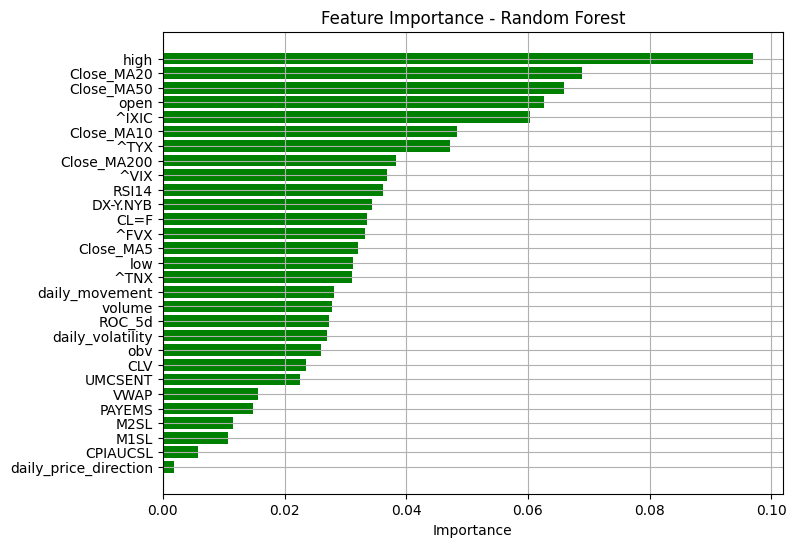

In [36]:
# @title
# Feature Importance

# Create a DataFrame with feature importances
feature_importance = pd.DataFrame({
    'Feature': predictors,
    'Importance': model.feature_importances_
})

# Sort by importance (descending)
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance)

# Optional: Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='green')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.grid(True)
plt.show()

In [37]:
test['Predicted_Change_pct'] = test['Predicted_Close_pct'] / test['close'] -1
test[['close', 'Target_Change_pct',	'Tomorrow','Predicted_Change_pct', 'Predicted_Close_pct']]

,close,Target_Change_pct,Tomorrow,Predicted_Change_pct,Predicted_Close_pct
Date,,,,,
2024-03-01,5137.08,-0.00119,5130.95,0.001413,5144.339208
2024-03-04,5130.95,-0.01019,5078.65,-0.000118,5130.345061
2024-03-05,5078.65,0.00514,5104.76,0.002032,5088.970325
2024-03-06,5104.76,0.01030,5157.36,0.002371,5116.865258
2024-03-07,5157.36,-0.00653,5123.69,0.001719,5166.223611
...,...,...,...,...,...
2025-02-21,6013.13,-0.00497,5983.25,-0.004107,5988.431670
2025-02-24,5983.25,-0.00468,5955.25,0.001338,5991.258181
2025-02-25,5955.25,0.00014,5956.06,-0.002305,5941.524141


In [38]:
test[['close', 'Target_Change_pct',	'Tomorrow','Predicted_Change_pct', 'Predicted_Close_pct']].describe()

# Create a copy for display where percentages are multiplied by 100
test_display = test.copy()

# Multiply the percentage columns by 100
test_display['Target_Change_pct'] = test_display['Target_Change_pct'] * 100
test_display['Predicted_Change_pct'] = test_display['Predicted_Change_pct'] * 100

# Now describe
test_display[['close', 'Target_Change_pct', 'Tomorrow', 'Predicted_Change_pct', 'Predicted_Close_pct']].describe()

,close,Target_Change_pct,Tomorrow,Predicted_Change_pct,Predicted_Close_pct
count,249.000000,249.000000,249.000000,249.000000,249.000000
mean,5603.022570,0.062683,5606.305382,-0.014843,5601.605079
std,334.437789,0.816013,333.857053,0.257435,324.658011
min,4967.230000,-2.997000,4967.230000,-0.922777,4981.566585
25%,5303.270000,-0.305000,5304.720000,-0.182887,5303.456110
50%,5597.120000,0.102000,5608.250000,0.016547,5604.591678
75%,5917.110000,0.554000,5918.250000,0.180467,5901.673569
max,6144.150000,2.530000,6144.150000,0.591543,6117.686941


Random Forest Model - Precision Score: 0.58
Random Forest Model - Recall Score: 0.55
Random Forest Model - Accuracy Score: 0.53


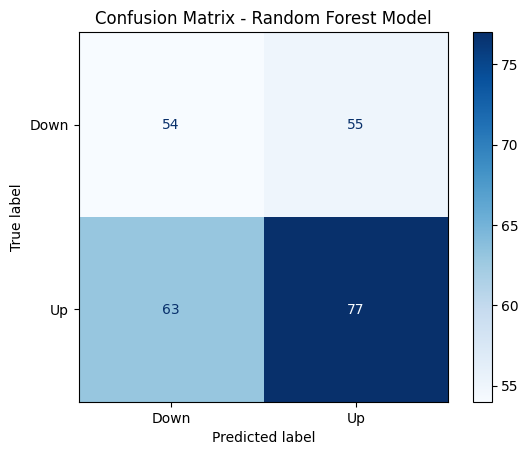

In [39]:
# @title
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict the direction (up/down) instead of exact value
test['Actual_Direction'] = (test['Tomorrow'] > test['close']).astype(int)
test['Predicted_Direction'] = (test['Predicted_Close_pct'] > test['close']).astype(int)

# Step 2: Calculate precision, recall, accuracy
precision_xgb = precision_score(test['Actual_Direction'], test['Predicted_Direction'])
recall_xgb = recall_score(test['Actual_Direction'], test['Predicted_Direction'])
accuracy_xgb = accuracy_score(test['Actual_Direction'], test['Predicted_Direction'])

# Step 3: Print the results
print(f"Random Forest Model - Precision Score: {precision_xgb:.2f}")
print(f"Random Forest Model - Recall Score: {recall_xgb:.2f}")
print(f"Random Forest Model - Accuracy Score: {accuracy_xgb:.2f}")

# Step 4: Create and display confusion matrix
cm = confusion_matrix(test['Actual_Direction'], test['Predicted_Direction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest Model')
plt.show()

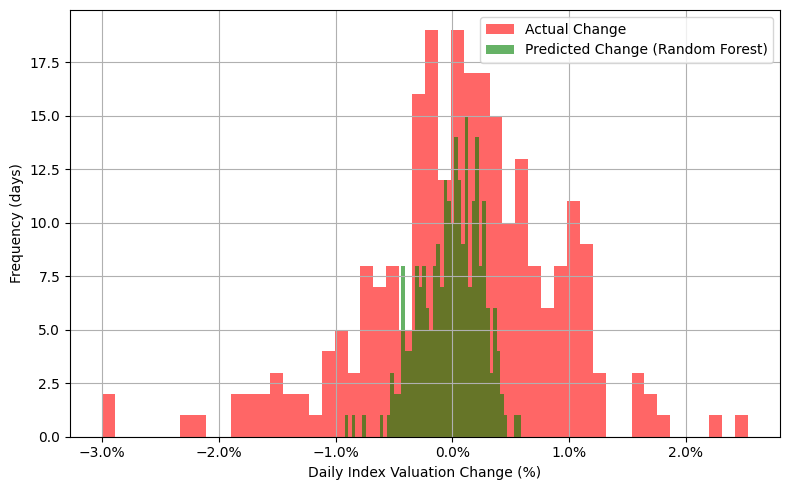

In [40]:
# @title
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.figure(figsize=(8, 5))

# Plot Target Change
plt.hist(test['Target_Change_pct'], bins=50, alpha=0.6, label='Actual Change', color='red')

# Plot Predicted Change
plt.hist(test['Predicted_Change_pct'], bins=50, alpha=0.6, label='Predicted Change (Random Forest)', color='green')

# Format x-axis as percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
# xmax=1 assumes your values are like 0.01 = 1%

plt.xlabel('Change (%)')
plt.ylabel('Frequency (days)')
plt.xlabel('Daily Index Valuation Change (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

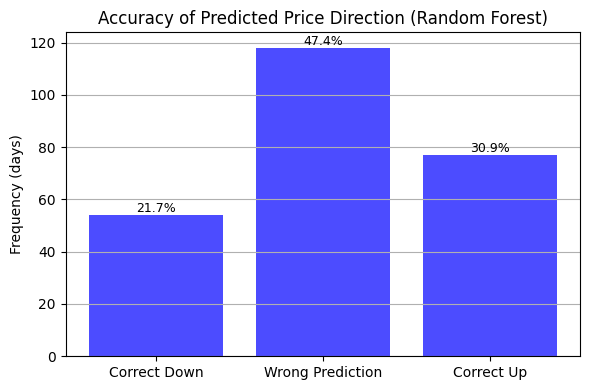

In [41]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# 1. Get the sign of Predicted and Target changes (already done earlier)
test['Predicted_Change_sign'] = np.sign(test['Predicted_Change_pct'])
test['Target_Change_sign'] = np.sign(test['Target_Change_pct'])

# 2. Create composite sign to check prediction correctness
test['sign_composite'] = test['Predicted_Change_sign'] + test['Target_Change_sign']

# 3. Count the frequency of each category
counts = test['sign_composite'].value_counts().sort_index()
percentages = (counts / counts.sum()) * 100

# 4. Create mapping for x-axis labels
label_mapping = {
    -2: 'Correct Down',
     0: 'Wrong Prediction',
     2: 'Correct Up'
}
labels = [label_mapping.get(x, str(x)) for x in counts.index]

# 5. Plot the bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts.values, color='blue', alpha=0.7)

# 6. Add labels and title
plt.ylabel('Frequency (days)')
plt.title('Accuracy of Predicted Price Direction (Random Forest)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# 7. Add percentage labels above bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{percentage:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# 8. Show plot
plt.tight_layout()
plt.show()


In [42]:
# Calculate MAE
mae = mean_absolute_error(test['Target_Change_pct']*100, test['Predicted_Change_pct']*100)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Target_Change_pct']*100, test['Predicted_Change_pct']*100))

print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")

Mean Absolute Error (MAE): 0.64600
Root Mean Squared Error (RMSE): 0.84324


In [43]:
# Multiply by 100 to convert to percentage
test_pct = test[['Target_Change_pct', 'Predicted_Change_pct']] * 100

# Describe the statistics
summary = test_pct.describe()

# Round to 2 decimal places
summary = summary.round(2)

# Add % sign to all except 'count'
for col in summary.columns:
    summary[col] = summary[col].astype(str) + '%'
summary.loc['count'] = test[['Target_Change_pct', 'Predicted_Change_pct']].count()

# Rename columns
summary = summary.rename(columns={
    'Target_Change_pct': 'Actual Daily Price Change',
    'Predicted_Change_pct': 'Predicted Daily Price Change'
})

# Display the summary
summary


,Actual Daily Price Change,Predicted Daily Price Change
count,249,249
mean,0.06%,-0.01%
std,0.82%,0.26%
min,-3.0%,-0.92%
25%,-0.3%,-0.18%
50%,0.1%,0.02%
75%,0.55%,0.18%
max,2.53%,0.59%




---



### **(3) S&P 500 NEXT DAY VALUATION PREDICTION USING XGBOOST**



---



In [13]:
!pip install xgboost

In [14]:
import pandas as pd
import pandas as pd
from google.colab import files
# 0. Imports
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
uploaded = files.upload()
df = pd.read_csv('master_df_sp500.csv')
df.head()

Saving master_df_sp500.csv to master_df_sp500 (1).csv


,close,high,low,open,volume,daily_volatility,daily_movement,ticker,^VIX,^IXIC,...,obv,cum_price_volume,cum_volume,VWAP,VWAP_deviation,CLV,relative_strength_nasdaq,relative_strength_nasdaq_norm,close_norm,^IXIC_norm
0,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,26.320068,-0.699951,^GSPC,17.790001,4726.810059,...,0.000000e+00,5.575046e+12,2708700000,2058.199951,0.000000,0.462002,0.435431,0.000000,0.000000,0.000000
1,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,37.099976,-33.859985,^GSPC,19.920000,4652.569824,...,-3.799120e+09,1.325147e+13,6507820000,2036.238238,-0.768981,0.087331,0.434293,-0.002613,-0.018278,-0.015706
2,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,37.810059,-19.540039,^GSPC,21.120001,4592.740234,...,-8.259230e+09,2.218333e+13,10967930000,2022.563305,-0.986536,0.268977,0.436038,0.001394,-0.027009,-0.028364
3,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,24.059937,20.349976,^GSPC,19.309999,4650.470215,...,-4.453750e+09,2.989285e+13,14773410000,2023.422810,0.122427,0.845803,0.435633,0.000465,-0.015693,-0.016150
4,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,33.470093,31.529907,^GSPC,17.010000,4736.189941,...,-5.197400e+08,3.800533e+13,18707420000,2031.564681,1.505008,0.942032,0.435401,-0.000070,0.001914,0.001984


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index("Date")

In [16]:
sp500 = df[['close', 'high', 'low', 'open', 'volume', 'daily_volatility',
       'daily_movement', 'ticker', '^VIX', '^IXIC', '^FVX', '^TNX',
       '^TYX', 'CL=F', 'DX-Y.NYB', 'VIX_pct_change', 'VIX_lag1', 'VIX_lag2',
       'M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS', 'UMCSENT', 'Close_MA5',
       'Close_MA10', 'Close_MA20', 'Close_MA50', 'Close_MA200', 'RSI14',
       'ROC_5d', 'daily_price_direction', 'obv', 'VWAP', 'VWAP_deviation', 'CLV',
       'relative_strength_nasdaq', 'relative_strength_nasdaq_norm',
       'close_norm', '^IXIC_norm']].copy()

sp500 = sp500.round(2)

# 4. Create Target: Predict Tomorrow's Change (not Close)
sp500["Target_Change_pct"] = sp500["close"].shift(-1) / sp500["close"] -1

In [17]:
import xgboost as xgb

predictors = [
    'close','high', 'low', 'open', 'volume',
    'daily_volatility', 'daily_movement', '^VIX', '^IXIC', '^FVX', '^TNX',
    '^TYX', 'CL=F', 'DX-Y.NYB',
    'M1SL', 'M2SL', 'CPIAUCSL', 'PAYEMS', 'UMCSENT', 'Close_MA5',
    'Close_MA10', 'Close_MA20', 'Close_MA50', 'Close_MA200', 'RSI14',
    'ROC_5d', 'daily_price_direction', 'obv', 'VWAP', 'CLV'
]

# 5. Train-Test Split (fixed rows for test - roughly 1 year)
train = sp500.iloc[:-250]
test = sp500.iloc[-250:]

| Parameter           | Description |
|---------------------|-------------|
| `n_estimators=300`   | Number of boosting rounds, meaning how many trees the model will build sequentially. |
| `learning_rate=0.01`| Controls how much each tree corrects the previous errors; lower values slow learning but often improve performance. |
| `max_depth=8`        | Maximum depth of each decision tree, controlling model complexity and how finely it can split data. |
| `subsample=0.8`      | Fraction of the training data randomly sampled to grow each tree, helping prevent overfitting. |
| `colsample_bytree=0.8`| Fraction of features randomly selected for each tree, improving model robustness and diversity. |
| `random_state=1`     | Fixes the random number generator seed for reproducibility of results. |
| `objective='reg:squarederror'` | Specifies the learning task as regression, minimizing the squared error between predicted and actual values. |

In [23]:
# Modeling: XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1,
    objective='reg:absoluteerror'
)

xgb_model.fit(train[predictors], train["Target_Change_pct"])

predicted_change_pct_xgb = xgb_model.predict(test[predictors])

In [19]:
# @title
test['Predicted_Change_pct_xgb'] = predicted_change_pct_xgb * 5

<ipython-input-19-096a57ea8f2a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Change_pct_xgb'] = predicted_change_pct_xgb * 5


In [24]:
# @title
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicting Close Price for tomorrow based on predicted % change
test['Predicted_Close_pct_xgb'] = test['close'] * (1 + predicted_change_pct_xgb)

# True Tomorrow Close (shifted actual)
test['Tomorrow'] = test['close'].shift(-1)

# Drop the last row (no 'Tomorrow' value available)
test = test.dropna()

# Calculate evaluation metrics
mae_xgb = mean_absolute_error(test['Tomorrow'], test['Predicted_Close_pct_xgb'])
rmse_xgb = np.sqrt(mean_squared_error(test['Tomorrow'], test['Predicted_Close_pct_xgb']))
r2_xgb = r2_score(test['Tomorrow'], test['Predicted_Close_pct_xgb'])

# Print evaluation results
print(f"XGBoost Model - Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"XGBoost Model - Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"XGBoost Model - R² Score: {r2_xgb:.2f}")

print(test[['Tomorrow', 'Predicted_Close_pct_xgb']].head(10))


XGBoost Model - Mean Absolute Error (MAE): 34.07
XGBoost Model - Root Mean Squared Error (RMSE): 45.58
XGBoost Model - R² Score: 0.98
            Tomorrow  Predicted_Close_pct_xgb
Date                                         
2024-03-01   5130.95              5140.786170
2024-03-04   5078.65              5136.803557
2024-03-05   5104.76              5087.553340
2024-03-06   5157.36              5111.197690
2024-03-07   5123.69              5156.464844
2024-03-08   5117.94              5134.768535
2024-03-11   5175.27              5126.989092
2024-03-12   5165.31              5175.038956
2024-03-13   5150.48              5166.314909
2024-03-14   5117.09              5158.547764


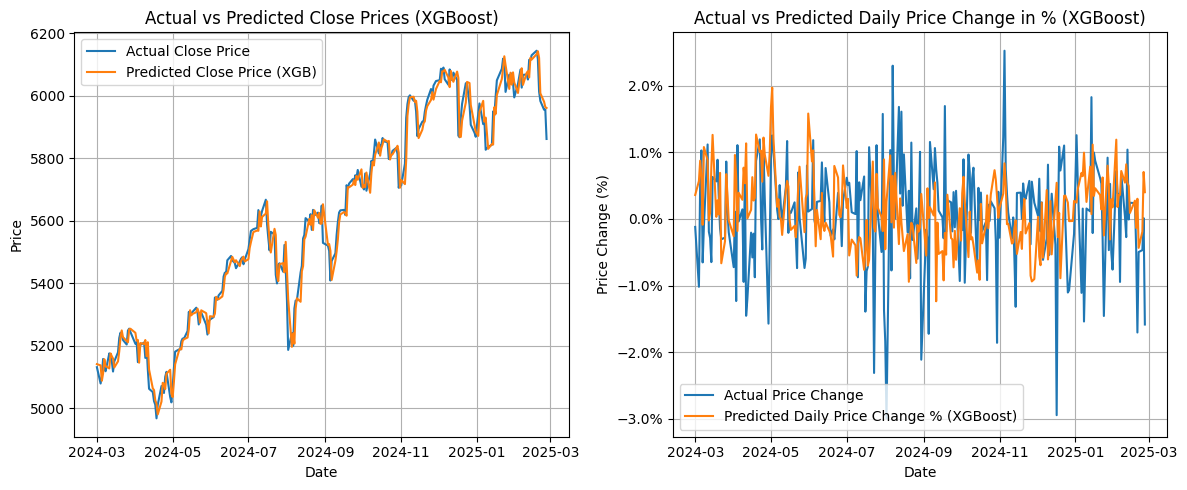

In [25]:
# @title
from matplotlib.ticker import PercentFormatter

# 9. Plotting Side by Side
plt.figure(figsize=(12, 5))  # Wider figure for side-by-side plots

# First plot (XGBoost)
plt.subplot(1, 2, 1)  # (rows=1, columns=2, first plot)
plt.plot(test.index, test['Tomorrow'], label='Actual Close Price')
plt.plot(test.index, test['Predicted_Close_pct_xgb'], label='Predicted Close Price (XGB)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Prices (XGBoost)')
plt.legend()
plt.grid(True)

# Second plot (XGBoost model)
plt.subplot(1, 2, 2)  # (rows=1, columns=2, second plot)
plt.plot(test.index, test['Target_Change_pct'], label='Actual Price Change')
plt.plot(test.index, test['Predicted_Change_pct_xgb'], label='Predicted Daily Price Change % (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.title('Actual vs Predicted Daily Price Change in % (XGBoost)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Format y-axis as %
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

XGBoost Model - Precision Score: 0.59
XGBoost Model - Recall Score: 0.60
XGBoost Model - Accuracy Score: 0.54


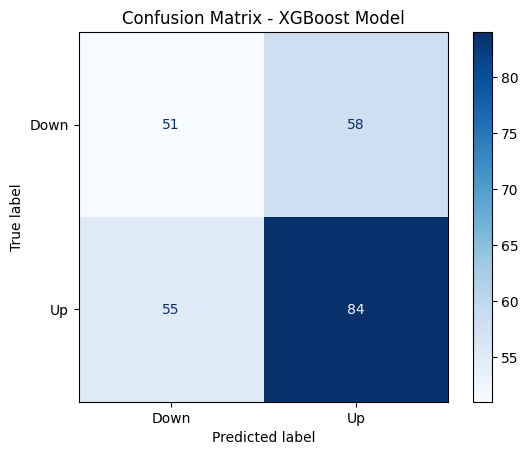

In [26]:
# @title
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict the direction (up/down) instead of exact value
test['Actual_Direction'] = (test['Tomorrow'] > test['close']).astype(int)
test['Predicted_Direction_xgb'] = (test['Predicted_Close_pct_xgb'] > test['close']).astype(int)

# Step 2: Calculate precision, recall, accuracy
precision_xgb = precision_score(test['Actual_Direction'], test['Predicted_Direction_xgb'])
recall_xgb = recall_score(test['Actual_Direction'], test['Predicted_Direction_xgb'])
accuracy_xgb = accuracy_score(test['Actual_Direction'], test['Predicted_Direction_xgb'])

# Step 3: Print the results
print(f"XGBoost Model - Precision Score: {precision_xgb:.2f}")
print(f"XGBoost Model - Recall Score: {recall_xgb:.2f}")
print(f"XGBoost Model - Accuracy Score: {accuracy_xgb:.2f}")

# Step 4: Create and display confusion matrix
cm = confusion_matrix(test['Actual_Direction'], test['Predicted_Direction_xgb'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGBoost Model')
plt.show()


                  Feature  Importance
16               CPIAUCSL    0.042305
27                    obv    0.039508
28                   VWAP    0.038557
17                 PAYEMS    0.037846
15                   M2SL    0.037599
25                 ROC_5d    0.036598
11                   ^TYX    0.036481
21             Close_MA20    0.036313
24                  RSI14    0.035902
20             Close_MA10    0.035119
18                UMCSENT    0.034709
23            Close_MA200    0.034452
14                   M1SL    0.034401
19              Close_MA5    0.034367
29                    CLV    0.034181
10                   ^TNX    0.034143
12                   CL=F    0.033938
26  daily_price_direction    0.033795
13               DX-Y.NYB    0.033763
8                   ^IXIC    0.033004
22             Close_MA50    0.032584
7                    ^VIX    0.031783
6          daily_movement    0.031341
9                    ^FVX    0.030507
5        daily_volatility    0.029459
4           

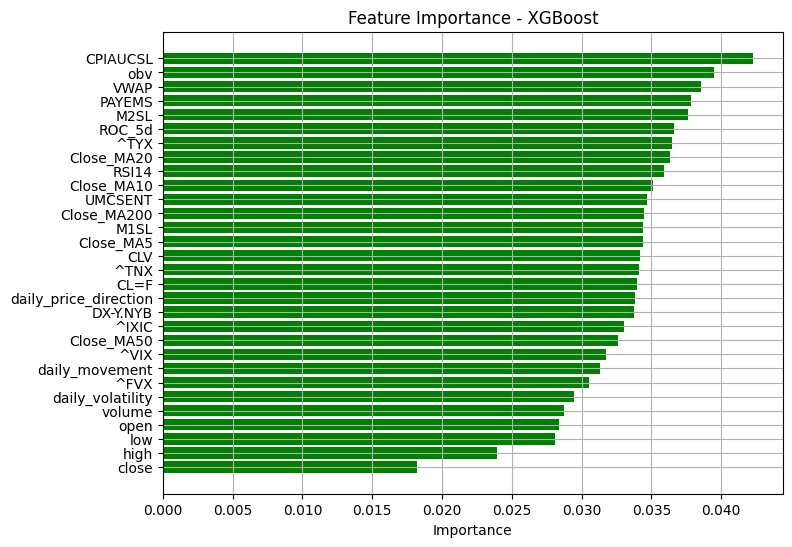

In [27]:
# Feature Importance

# Create a DataFrame with feature importances
feature_importance_xgb = pd.DataFrame({
    'Feature': predictors,
    'Importance': xgb_model.feature_importances_
})

# Sort by importance (descending)
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importance_xgb)

# Optional: Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'], color='green')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.grid(True)
plt.show()

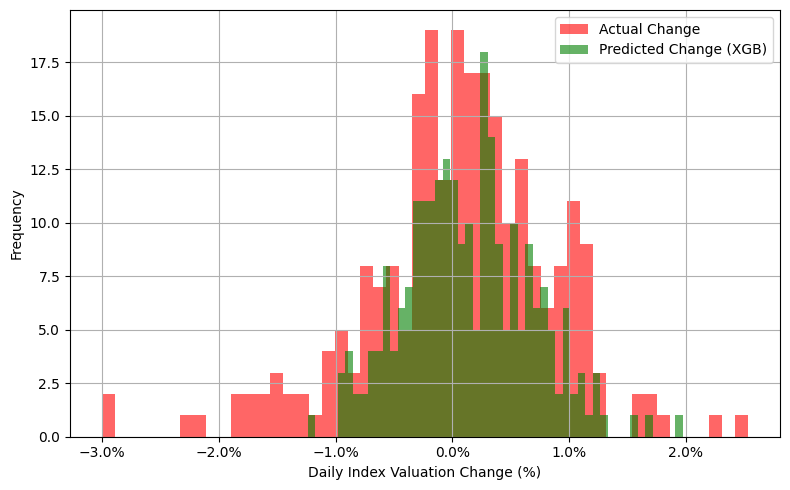

In [28]:
# @title
import matplotlib.ticker as mtick  # <- you need this!

# Multiply by 100 to convert to % for plotting
test['Target_Change_pct_plot'] = test['Target_Change_pct'] * 100
test['Predicted_Change_pct_xgb_plot'] = test['Predicted_Change_pct_xgb'] * 100

# Plot
plt.figure(figsize=(8, 5))
plt.hist(test['Target_Change_pct_plot'], bins=50, alpha=0.6, label='Actual Change', color='red')
plt.hist(test['Predicted_Change_pct_xgb_plot'], bins=50, alpha=0.6, label='Predicted Change (XGB)', color='green')

# Now format x-axis as % (xmax=100 because values are in real percent)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.xlabel('Daily Index Valuation Change (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

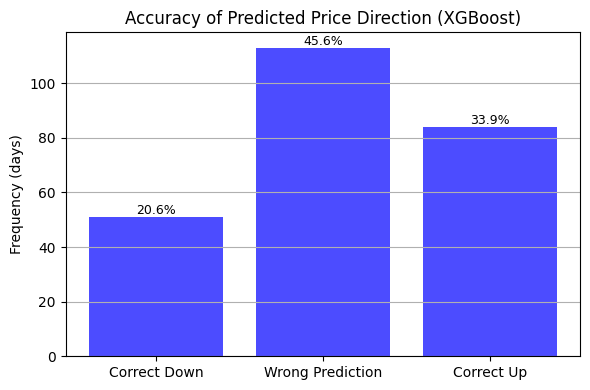

In [29]:
# @title

import numpy as np
import matplotlib.pyplot as plt

# Sign agreement
test['Predicted_Change_sign_xgb'] = np.sign(test['Predicted_Change_pct_xgb'])
test['Target_Change_sign'] = np.sign(test['Target_Change_pct'])
test['sign_composite_xgb'] = test['Predicted_Change_sign_xgb'] + test['Target_Change_sign']

# Count the frequency of each category
counts_xgb = test['sign_composite_xgb'].value_counts().sort_index()
percentages_xgb = (counts_xgb / counts_xgb.sum()) * 100

# Create mapping for x-axis labels
label_mapping = {
    -2: 'Correct Down',
     0: 'Wrong Prediction',
     2: 'Correct Up'
}
labels_xgb = [label_mapping.get(x, str(x)) for x in counts_xgb.index]

# Plot the bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(labels_xgb, counts_xgb.values, color='blue', alpha=0.7)

# Add labels and title
plt.ylabel('Frequency (days)')
plt.title('Accuracy of Predicted Price Direction (XGBoost)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Add percentage labels above bars
for bar, percentage in zip(bars, percentages_xgb):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{percentage:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Show plot
plt.tight_layout()
plt.show()

In [30]:
# Calculate MAE
mae = mean_absolute_error(test['Target_Change_pct']*100, test['Predicted_Change_pct_xgb']*100)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Target_Change_pct']*100, test['Predicted_Change_pct_xgb']*100))

print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")

Mean Absolute Error (MAE): 0.72148
Root Mean Squared Error (RMSE): 0.95119


In [31]:
# Multiply by 100 to convert to percentage
test_pct = test[['Target_Change_pct', 'Predicted_Change_pct_xgb']] * 100

# Describe the statistics
summary = test_pct.describe()

# Round to 2 decimal places
summary = summary.round(2)

# Add % sign to all except 'count'
for col in summary.columns:
    summary[col] = summary[col].astype(str) + '%'
summary.loc['count'] = test[['Target_Change_pct', 'Predicted_Change_pct_xgb']].count()

# Rename columns
summary = summary.rename(columns={
    'Target_Change_pct': 'Actual Daily Price Change',
    'Predicted_Change_pct_xgb': 'Predicted Daily Price Change'
})

# Display the summary
summary

,Actual Daily Price Change,Predicted Daily Price Change
count,248,248
mean,0.06%,0.14%
std,0.81%,0.54%
min,-3.0%,-1.24%
25%,-0.31%,-0.24%
50%,0.1%,0.12%
75%,0.55%,0.5%
max,2.53%,1.97%




---



## **PERFORMANCE COMPARISON** ##

Random Forest

Mean Absolute Error (MAE): 0.67%
Root Mean Squared Error (RMSE): 0.84%

XGBoost

Mean Absolute Error (MAE): 0.73%
Root Mean Squared Error (RMSE): 0.96%

| Statistic        | Actual | Predicted Random Forest | Predicted XGBoost |
|:-----------------|---------------------------:|--------------------------------------------:|--------------------------------------:|
| **Count**        | 249                         | 249                                          | 249                                  |
| **Mean**         | 0.06%                       | -0.01%                                       | 0.14%                                |
| **Std**          | 0.82%                       | 0.26%                                        | 0.54%                                |
| **Min**          | -3.0%                       | -0.92%                                       | -1.24%                               |
| **25%**          | -0.3%                       | -0.18%                                       | -0.24%                               |
| **50% (Median)** | 0.1%                        | 0.02%                                        | 0.11%                                |
| **75%**          | 0.55%                       | 0.18%                                        | 0.5%                                 |
| **Max**          | 2.53%                       | 0.59%                                        | 1.97%                                |

Random Forest Model - Precision Score: 0.58 Random Forest Model - Recall Score: 0.55 Random Forest Model - Accuracy Score: 0.53

XGBoost Model - Precision Score: 0.59 XGBoost Model - Recall Score: 0.60 XGBoost Model - Accuracy Score: 0.54

| Metric           | Random Forest | XGBoost |
|:-----------------|---------------:|--------:|
| **Precision Score** | 58%         | 59%    |
| **Recall Score**    | 55%         | 60%    |
| **Accuracy Score**  | 53%         | 54%    |